## Anitbiotic Drug Discovery: Executive Summary
   
This report was commissioned to develop a robust, fast, and reproducible drug discovery pipeline for new antibiotics, in an effort to combat antibiotic resistance. After in-depth analysis, conclusions and recommendations will be presented.
   
Data was obtained from the following source:
- Comprehensive Antibiotic Resistance Database via CARD CLI interface: 
 - https://card.mcmaster.ca
- ChEMBL via Python client library: 
 - https://www.ebi.ac.uk/chembl/  


In the coming years, it will become crucial to develop drug discovery pipelines using machine learning to expedite the search for new antibiotics. Towse et al. estimate the cost of developing a new antibiotic via the traditional research pipeline could cost over 1.7B USD, and take over 10 years. This makes for a bleak future, where more strains of bacteria become resistant to traditional antibiotics each day, and pharmaceutical companies do not see a cost-benefit to researching new drugs. Machine learning based drug discovery aims to take several years and hundreds of millions of USD off of the current estimates. With this goal in mind, one bacteria, Acinetobacter baumannii, was chosen, and a series of drugs with a recorded efficacy were aggregated using the ChEMBL web-resources client. These results were not filtered for Lipinski's rule of 5, as current research indicates these rules do not apply to antibiotics. The entire pipeline was optimized to be adaptable to any organism search. 

After obtaining and exploring data for over 4000 compounds, functions were engineered to classify and featurize the molecules. First, each molecule was rated as "active", "intermediate," or "inactive" based on the recorded standard value - a nM scale representation of potency. Next, features were engineered using the RDKit library. Columns were added for logP, molecular weight, number of proton donors, and number of proton acceptors. The functions were designed for flexibility in adding additional features. The final featurization step used the RDKit Morgan fingerprint method to binarize each molecule based on a combination of atoms and functional groups. This method of vectorization will allow us to look at the most important molecular fragments when performing feature extraction.

After featurizing each compound, each numerical feature was scaled using SKLearn's StandardScaler, and LazyPredict was used to search for the best potential models. HistGradient Boosting regression and classification models performed at the highest level, and were ultimately chosen due to their speed, compared to other high performing models such as SVM or Tensorflow neural nets(NN models using only bits). For the classification model, the best accuracy was achieved after dropping the "intermediate" rated compounds. For regression, all values were included, and the best results were obtained after standardizing the distribution of the target values. Attempts at dimensionality reduction yielded slightly greater results, but were abandoned due to the importance of analyzing residuals and feature importances, as well maintaining robustness for other bacteria searches. Utlimately, due the volume of sparsely populated fragments, variance threshold will be added as pre-processing step in the Streamlit application.

The regression model, after hyperparameter tuning with GridSearchCV, ultimately had an r<sup>2</sup> of 0.764(test), and performed 77.6% greater than a null model. The residuals were used to identify the molecules that the model had the most difficulty predicting efficacy for, and cosine similarity was generated as a tool for researchers to analyze functional groups that need more attention to be properly modeled.

The classfication model, also tuned using GridSearchCV, was ultimately able to predict active vs inactive with an accuracy of 0.98, precision of 0.96, recall equal to 0.97, f1-score of 0.97, and a roc auc of 0.98. Specific "bits" were noted as having significant feature importance, these bits were extracted using the RDKit library, and visualized in notebook 04b. These fragments are important for determing necessary functional groups. The top residuals were also explored, to determine which molecular features the models struggled most with. The fragments were also explored, and the results can be found in notebook 04a.

After successfully performing regression and classification on Acinetobacter baumannii targeting drugs, an app was developed to model the drugs available for any organism, and make a prediction on the Minimum Inhibitory Concentration (MIC) of a new molecule. The app takes in an organism name and a SMILE from the user, and outputs the desired prediction, along with an image of the molecule, and a description of its physical properties. Behind the scenes, the ChEMBL web-client is querying for drugs, and several functions are adding features and modeling. The app was deployed using Streamlit.

Finally, work was put toward developing a unique molecule generator, again using Acinetobacter baumannii classified drugs. The compounds were filtered for effectiveness, and the resulting molecules were fed into an RNN with LSTM layers, using a text generation technique adapted from Deep Learning with Python. This is a work in-progress, but unique, new strings were generated. Furthermore, even when computing on a remote PC with a GPU, only 300 molecules could be used for training, due to the size of the 3d array.

Based on the findings, and to answer the problem statement, a fast, reliable drug discovery pipeline can be, and was, produced. Starting with an organism of interest, a researcher can use the developed pipeline and application to research what drugs have worked, what molecular pieces are important, and make predictions on new compounds.

Credit: https://github.com/csinnott0219/Projects/tree/main/Anitbiotic_Drug_Discovery

In [ ]:
# Install dependencies / requirements
!pip install chembl_webresource_client rdkit-pypi==2021.3.1.5 padelpy lazypredict yellowbrick streamlit dtreeviz pygccxml pyplusplus

### Drug Import and Featurization I

Import Libraries

In [2]:
import pandas as pd
from chembl_webresource_client.new_client import new_client
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [3]:
import warnings
warnings.filterwarnings("ignore")

#### Developing Search Pipeline

* Using one randomly chosen bacteria: Acinetobacter baumannii

Accessing ChEMBL database via web-client:

In [4]:
target = new_client.target

In [5]:
target_search = target.search('Acinetobacter baumannii')

In [6]:
target_df = pd.DataFrame.from_dict(target_search)

In [7]:
target_df.head(10)

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Acinetobacter baumannii,Acinetobacter baumannii,32.0,False,CHEMBL614425,[],ORGANISM,470
1,[],Acinetobacter,Acinetobacter,16.0,False,CHEMBL614424,[],ORGANISM,469
2,[],Acinetobacter calcoaceticus,Acinetobacter calcoaceticus,14.0,False,CHEMBL614426,[],ORGANISM,471
3,[],Acinetobacter sp.,Acinetobacter sp.,14.0,False,CHEMBL614427,[],ORGANISM,472
4,[],Acinetobacter lwoffii,Acinetobacter lwoffii,14.0,False,CHEMBL613778,[],ORGANISM,28090
5,[],Acinetobacter haemolyticus,Acinetobacter haemolyticus,14.0,False,CHEMBL613782,[],ORGANISM,29430
6,[],Acinetobacter radioresistens,Acinetobacter radioresistens,14.0,False,CHEMBL2366968,[],ORGANISM,40216
7,[],Acinetobacter pittii,Acinetobacter pittii,14.0,False,CHEMBL3140321,[],ORGANISM,48296
8,[],Acinetobacter calcoaceticus subsp. anitratus,Acinetobacter calcoaceticus subsp. anitratus,11.0,False,CHEMBL612453,[],ORGANISM,107673
9,"[{'xref_id': 'Q2TR58', 'xref_name': None, 'xre...",Acinetobacter baumannii,Carbapenem-hydrolyzing oxacillinase OXA-58,11.0,False,CHEMBL5153,"[{'accession': 'Q2TR58', 'component_descriptio...",SINGLE PROTEIN,470


In [8]:
#picking based on visual inspection
#choosing a broader term for more results

select_target = target_df.target_chembl_id[0]

In [9]:
select_target #verifying

'CHEMBL614425'

In [10]:
activity = new_client.activity

Filtering for results that have an Minimum Inhibitory Concentration (MIC) value:

In [11]:
#trying to filter by MIC occasionally breaks kernel
# -> works consistently in app

res = activity.filter(target_chembl_id = select_target).filter(standard_type=['MIC'])

In [12]:
df_test = pd.DataFrame.from_dict(res)

In [13]:
df_test.sample(5)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
3173,None,5211180,[],CHEMBL1679718,Antimicrobial activity against ISAba1 linked w...,F,None,None,BAO_0002146,BAO_0000218,...,Acinetobacter baumannii,Acinetobacter baumannii,470,None,None,MIC,ug ml-1,UO_0000274,None,16.0
5539,None,18284206,[],CHEMBL4121017,Antibacterial activity against Acinetobacter b...,F,None,None,BAO_0002146,BAO_0000218,...,Acinetobacter baumannii,Acinetobacter baumannii,470,None,None,MIC,ug ml-1,UO_0000274,None,2.0
102,None,2128718,[],CHEMBL940194,Antimicrobial activity against Acinetobacter b...,F,None,None,BAO_0002146,BAO_0000218,...,Acinetobacter baumannii,Acinetobacter baumannii,470,None,None,MIC,ug ml-1,UO_0000274,None,12.0
4123,None,13908239,[],CHEMBL3119310,Antimicrobial activity against Acinetobacter b...,F,None,None,BAO_0002146,BAO_0000218,...,Acinetobacter baumannii,Acinetobacter baumannii,470,None,None,MIC,ug ml-1,UO_0000274,None,128.0
8770,Median N= 4; Maxinhib -0.2 Pct,20180435,[],CHEMBL4296188,Antibacterial activity against Acinetobacter b...,F,None,None,BAO_0002146,BAO_0000218,...,Acinetobacter baumannii,Acinetobacter baumannii,470,None,None,MIC,ug.mL-1,UO_0000274,None,32.0


In [14]:
df_test.shape

(9468, 45)

In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9468 entries, 0 to 9467
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   activity_comment           1405 non-null   object 
 1   activity_id                9468 non-null   int64  
 2   activity_properties        9468 non-null   object 
 3   assay_chembl_id            9468 non-null   object 
 4   assay_description          9468 non-null   object 
 5   assay_type                 9468 non-null   object 
 6   assay_variant_accession    0 non-null      object 
 7   assay_variant_mutation     0 non-null      object 
 8   bao_endpoint               9468 non-null   object 
 9   bao_format                 9468 non-null   object 
 10  bao_label                  9468 non-null   object 
 11  canonical_smiles           9436 non-null   object 
 12  data_validity_comment      235 non-null    object 
 13  data_validity_description  235 non-null    objec

In [16]:
df_test['standard_value'].isna().value_counts()

False    9160
True      308
Name: standard_value, dtype: int64

In [17]:
df_test['standard_value'] = df_test['standard_value'].astype(float)

In [18]:
#dropping null standard values
df_test = df_test.dropna(subset = ['standard_value'])

In [19]:
df_test.shape

(9160, 45)

In [20]:
df_test.set_index(keys = 'molecule_chembl_id', inplace = True)

In [21]:
# the standard value column accounts for the different units
# all converted to nM
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3965067/
df_test['units'].value_counts()

ug ml-1        6034
uM             2419
mg/L            372
ug.mL-1         214
mM               49
umol/ml          30
mg/ml            27
mg l-1            7
ug/L              4
10'-4 ug/ml       2
uM/ml             1
nM                1
Name: units, dtype: int64

In [22]:
df_test['standard_value'].describe()

count    9.160000e+03
mean     3.394642e+04
std      2.122256e+05
min      9.800000e-04
25%      7.725000e+00
50%      3.200000e+01
75%      1.024000e+03
max      8.000000e+06
Name: standard_value, dtype: float64

In [23]:
df_trim = df_test[['canonical_smiles', 'standard_value']]

Classifying results:

In [24]:
#separate column for binary classification

def binary_bioactivity_rater(col):
    """
    """
    bio_activity_rate_binary = []
    for i in col:
        if i <= 33: # need to research; for now tuned to get balanced classes
            bio_activity_rate_binary.append('active')
        else:
            bio_activity_rate_binary.append('inactive')
            
    bioactivity_binary = pd.Series(bio_activity_rate_binary)
    
    return bioactivity_binary

In [25]:
df_trim['bioactivity_binary'] = np.where(df_trim['standard_value'] < 33, 'active', 'inactive')

In [26]:
df_trim['bioactivity_binary_class'] = np.where(df_trim['standard_value'] > 33, 0, 1)

In [27]:
df_trim.shape

(9160, 4)

In [28]:
#creating column for multiclass classification

def bioactivity_rater(df, col):
    """
    """
    bio_activity_rate = []
    for i in col:
        if i <= 25: # need to research; for now tuned to get balanced classes
            bio_activity_rate.append('active')
        elif i > 500:
            bio_activity_rate.append('inactive')
#         elif i > 1000 and i < 9000:
#             bio_activity_rate.append('intermediate_weak') # too few in this class
        else:
            bio_activity_rate.append('intermediate')
            
    bioactivity_multiclass = pd.Series(bio_activity_rate, name = 'bioactivity_multiclass')
    df_merge = pd.concat([df.reset_index(), bioactivity_multiclass], axis = 1)
    
    return df_merge

In [29]:
df_trim = bioactivity_rater(df_trim, df_trim['standard_value'])

In [30]:
df_trim.sample(5)

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass
2248,CHEMBL1630675,Cc1c(CC(=O)N[C@@H](C)C(=O)O)c(=O)oc2c(C)c3occ(...,256.0,inactive,0,intermediate
9124,CHEMBL77305,CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c([N+](=...,20000.0,inactive,0,inactive
2151,CHEMBL1436,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(COC(N)...,32.0,active,1,intermediate
2418,CHEMBL1730,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(COC(C)...,8.0,active,1,active
8303,CHEMBL4587114,Cc1ncc(Cn2cc(CCOS(C)(=O)=O)nn2)c(N)n1,32.0,active,1,intermediate


In [31]:
# may need to append a bulk list of other antibiotics
# or drop intermediates to get enough separation b/n classes
df_trim['bioactivity_multiclass'].value_counts()

active          3633
intermediate    2955
inactive        2572
Name: bioactivity_multiclass, dtype: int64

In [32]:
#convert multiclass column to binary and acheive better separation
# by deleting intermediate
df_trim['bioactivity_binary'].value_counts()

active      4638
inactive    4522
Name: bioactivity_binary, dtype: int64

In [33]:
df = df_trim

In [34]:
df.shape

(9160, 6)

Exporting results:

In [35]:
df.to_csv('acinetobacter_baumannii_MIC.csv')

#### Feature Engineering

* Adding Lipinski Descriptors via RDKit library
    * Molecular weight
    * log-p
    * Proton donors
    * Proton acceptors

In [36]:
df.canonical_smiles.isna().value_counts()

False    9128
True       32
Name: canonical_smiles, dtype: int64

In [37]:
df = df.dropna(subset = ['canonical_smiles']).drop(columns = 'molecule_chembl_id')

In [38]:
df.shape

(9128, 5)

In [39]:
%%time
#proof of concept for function
test = [round(Descriptors.MolWt(Chem.MolFromSmiles(i)), 3) for i in df['canonical_smiles']]

CPU times: user 3.22 s, sys: 0 ns, total: 3.22 s
Wall time: 3.22 s


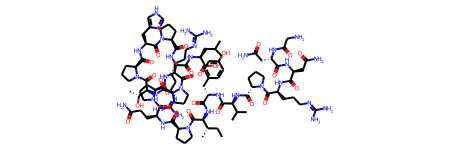

In [40]:
Chem.MolFromSmiles(df.canonical_smiles[4])

In [41]:
df.canonical_smiles[4]

'CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCN=C(N)N)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(N)=O)NC(=O)CN)C(C)C)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(N)=O)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCCN=C(N)N)C(=O)N1CCC[C@H]1C(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)N[C@@H](Cc1c[nH]cn1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCCN=C(N)N)C(=O)N[C@@H](CC(C)C)C(=O)O)[C@@H](C)O'

In [42]:
test[4]

2209.551

In [43]:
# antibiotics do not necessarily obey the Lipinski rule of 5
# therefore not filtering or setting limits
# but the extra features may be valuable
# ref: https://pubs.acs.org/doi/10.1021/acsinfecdis.5b00044
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def add_mol_feats(df, df_col):
    """
    Creates a new dataframe with four new molecular descriptors: molecular
    weight, log P, proton donors, and proton acceptors.
    
    Args: dataframe column containing SMILES
    
    Returns: new dataframe of molecular features
    """
    mol_wt   = [round(Descriptors.MolWt(Chem.MolFromSmiles(i)), 3) for i in df_col]
    log_p    = [Descriptors.MolLogP(Chem.MolFromSmiles(i)) for i in df_col]
    H_donors = [Lipinski.NumHDonors(Chem.MolFromSmiles(i)) for i in df_col]
    H_accept = [Lipinski.NumHAcceptors(Chem.MolFromSmiles(i)) for i in df_col]
    # can add more features after modeling
    
    mol_array = np.array([mol_wt,
                          log_p,
                          H_donors,
                          H_accept])
    
    mol_array_trans = np.transpose(mol_array)
    
    mol_df = pd.DataFrame(data = mol_array_trans, 
                          columns = [
                            'mol_wt',
                            'log_p',
                            'proton_donors',
                            'proton_acceptors'
                                        ])
    
    df_merge = pd.concat([df.reset_index(), mol_df], axis = 1)
    
    return df_merge #O(n^4)

In [44]:
%%time
df_feats = add_mol_feats(df, df['canonical_smiles']).drop(columns = ['index'])

CPU times: user 20 s, sys: 0 ns, total: 20 s
Wall time: 20 s


In [45]:
df.shape

(9128, 5)

In [46]:
df_feats.shape

(9128, 9)

In [47]:
df_feats.sample(3)

,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass,mol_wt,log_p,proton_donors,proton_acceptors
2982,C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(SCCNC=N)C[C...,16.0,active,1,active,299.352,-0.17603,4.0,5.0
1127,Nn1c(-c2ccc(S(=O)(=O)c3ccc(Cl)cc3)cc2)n[nH]c1=S,128.0,inactive,0,intermediate,366.855,2.80769,2.0,6.0
4725,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...,2.0,active,1,active,480.572,-1.27990,2.0,10.0


Exporting results:

In [48]:
df_feats.to_csv('acinetobacter_baumannii_MIC_addFeats.csv')

### Drug Import and Featurization II

Import Libraries

In [49]:
import pandas as pd
from chembl_webresource_client.new_client import new_client
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
#cmd line wrapper for PaDEL
from padelpy import from_smiles
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys

In [50]:
import warnings
warnings.filterwarnings("ignore")

Data Import

In [51]:
df = pd.read_csv('acinetobacter_baumannii_MIC_addFeats.csv').drop(columns = 'Unnamed: 0')

In [52]:
df.sample(3)

,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass,mol_wt,log_p,proton_donors,proton_acceptors
5299,COc1ccc2ccc(=O)n(C[C@H](O)[C@@H]3CC[C@@H](NCc4...,0.5,active,1,active,484.578,1.98290,2.0,10.0
1030,CC(C)CCCCC(=O)N[C@@H](CCN)C(=O)N[C@@H](CN[C@@H...,1.0,active,1,active,2296.971,-10.32610,36.0,36.0
8813,CC(C)(C)c1cccc(-c2nc3cc(C(=N)N)ccc3[nH]2)c1O,20000.0,inactive,0,inactive,308.385,3.51707,4.0,3.0


In [53]:
len(df.canonical_smiles[5796])

33

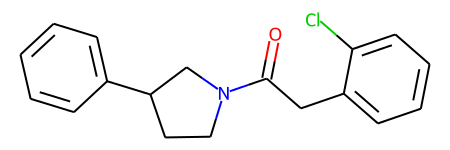

In [54]:
Chem.MolFromSmiles(df.canonical_smiles[5796])

#### SMILES Vectorization

PadelPy Test

In [55]:
#test - runs software externally then inputs
from_smiles(smiles = df.canonical_smiles[5796], fingerprints = True, descriptors = False)

OrderedDict([('PubchemFP0', '1'),
             ('PubchemFP1', '1'),
             ('PubchemFP2', '1'),
             ('PubchemFP3', '0'),
             ('PubchemFP4', '0'),
             ('PubchemFP5', '0'),
             ('PubchemFP6', '0'),
             ('PubchemFP7', '0'),
             ('PubchemFP8', '0'),
             ('PubchemFP9', '1'),
             ('PubchemFP10', '1'),
             ('PubchemFP11', '1'),
             ('PubchemFP12', '1'),
             ('PubchemFP13', '0'),
             ('PubchemFP14', '1'),
             ('PubchemFP15', '0'),
             ('PubchemFP16', '0'),
             ('PubchemFP17', '0'),
             ('PubchemFP18', '1'),
             ('PubchemFP19', '0'),
             ('PubchemFP20', '0'),
             ('PubchemFP21', '0'),
             ('PubchemFP22', '0'),
             ('PubchemFP23', '0'),
             ('PubchemFP24', '0'),
             ('PubchemFP25', '0'),
             ('PubchemFP26', '0'),
             ('PubchemFP27', '0'),
             ('PubchemFP28', '

In [56]:
len([i for i in df.canonical_smiles if len(i) < 30])

327

In [57]:
#proof of concept using subset of small molecules

# %%time
# fingerprint_test = [(from_smiles(smiles = i, fingerprints = True, 
#                      descriptors = False)) for i in df.canonical_smiles if len(i) < 30]

#opens and closes software for each row!
#df would take ~12hrs
#need faster option

In [58]:
# fingerprint_test[0]

In [59]:
# len(fingerprint_test)

In [61]:
%%time
ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(i), 3) for i in df.canonical_smiles]

CPU times: user 5.34 s, sys: 0 ns, total: 5.34 s
Wall time: 5.34 s


In [62]:
ECFP6_list = [list(i) for i in ECFP6]

In [63]:
ECFP6_names = [f'Bit_{i}' for i in range(2048)]

In [64]:
ECFP6_df = pd.DataFrame(ECFP6_list, index = df.index, columns = ECFP6_names)

In [65]:
#going forward with this method
ECFP6_df.sample(3)

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_2038,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047
8168,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
896,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4355,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
#defining a function to do the above method
def finger_printer (df, col):
    """
    Creates a vectorized representation of SMILES using Morgan's Fingerprint Algorithm
    
    Args: Dataframe, dataframe column with SMILES
    Returns: Dataframe with fingerprints
    """
    vects = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(i), 3) for i in col] 
    vect_list = [list(i) for i in ECFP6]
    vect_names = [f'Bit_{i}' for i in range(2048)]
    vect_df = pd.DataFrame(ECFP6_list, index = df.index, columns = ECFP6_names)
    
    merge_df = pd.concat([df.reset_index(drop = True), vect_df], axis = 1)
    
    return merge_df #O(n^3)

In [67]:
%%time
df_bits = finger_printer(df, df.canonical_smiles)

CPU times: user 26.4 s, sys: 257 ms, total: 26.6 s
Wall time: 26.6 s


In [68]:
df_bits.shape

(9128, 2057)

In [69]:
df_bits.sample(4)

,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass,mol_wt,log_p,proton_donors,proton_acceptors,Bit_0,...,Bit_2038,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047
2233,O=C(Nc1nnc(-c2ccc(Cl)cc2)o1)c1cccc(Br)c1,256.0,inactive,0,intermediate,378.613,4.4048,1.0,4.0,0,...,0,0,0,0,0,0,0,0,0,0
7324,C/C1=C\[C@H](O)C[C@]2(C)O[C@H]2C[C@@]2(C)C(=O)...,100.0,inactive,0,intermediate,318.457,3.8127,1.0,3.0,0,...,0,0,0,0,0,0,0,0,0,0
1090,CN(C)c1cc(NC(=O)CNC(C)(C)C)c(O)c2c1C[C@H]1C[C@...,0.5,active,1,active,585.658,0.5132,7.0,11.0,0,...,0,0,0,0,0,0,0,0,0,0
5848,CC(=O)NC[C@H]1CN(c2ccc(N3CCN(C(=O)CNC(=O)OCC4=...,50000.0,inactive,0,inactive,896.830,0.7337,6.0,13.0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
df_bits.to_csv('acinetobacter_baumannii_MIC_addFeats_addBits.csv')

### Drug Discovery Model Search

Import Libraries

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import VarianceThreshold

from lazypredict.Supervised import Classification, Regression

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score,\
                            precision_score, recall_score, roc_auc_score,\
                            mean_squared_error, mean_absolute_error, r2_score,\
                            plot_confusion_matrix, classification_report, \
                            plot_roc_curve, f1_score

Data Import and Cleaning

In [72]:
df = pd.read_csv('acinetobacter_baumannii_MIC_addFeats_addBits.csv').drop(columns = 
                        'Unnamed: 0').drop_duplicates(subset = ['canonical_smiles'])

In [73]:
df.sample(3)

,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass,mol_wt,log_p,proton_donors,proton_acceptors,Bit_0,...,Bit_2038,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047
6759,CCCCCCN1CCN(c2ccc3c4c(cccc24)C(=O)N(CC(O)Cn2c(...,13000.00,inactive,0,inactive,548.64,3.61,1.00,9.00,0,...,1,0,0,0,0,0,0,0,0,0
1474,Cc1ccc2c(c1)[nH]c1c2c(F)cc2c(=O)c(C(=O)O)cn(C3...,100.00,inactive,0,intermediate,350.35,4.12,2.00,3.00,0,...,0,0,0,0,0,0,0,0,0,0
3578,Clc1ccc(/N=N/c2c(-c3ccc(Cl)cc3)[nH]c3ccccc23)cc1,100000.00,inactive,0,inactive,366.25,7.56,1.00,2.00,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
#first test with subset not containing intermediate efficacy
df_small = df[df.bioactivity_multiclass != 'intermediate']

In [75]:
df_small.bioactivity_multiclass.value_counts()

inactive    1618
active      1092
Name: bioactivity_multiclass, dtype: int64

In [76]:
num_cols = ['mol_wt', 'log_p', 'proton_donors', 'proton_acceptors']

In [77]:
ss = StandardScaler()

In [78]:
df_small[num_cols] = ss.fit_transform(df_small[num_cols])
df[num_cols] = ss.fit_transform(df[num_cols])

In [79]:
X = df_small.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass'])
y = df_small['bioactivity_binary_class']

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [81]:
print(f'Null model accuracy: {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

Null model accuracy: 0.6


#### Classification Search

Binary Classification, No intermediate values

In [82]:
clf = Classification()

In [83]:
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [01:25<00:00,  2.95s/it]


In [84]:
models[0:20]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.96,0.95,0.95,0.96,2.25
ExtraTreesClassifier,0.96,0.95,0.95,0.96,1.47
XGBClassifier,0.95,0.95,0.95,0.95,6.86
RandomForestClassifier,0.95,0.94,0.94,0.95,1.21
SVC,0.95,0.94,0.94,0.95,11.98
LogisticRegression,0.94,0.94,0.94,0.94,0.70
BaggingClassifier,0.94,0.94,0.94,0.94,2.53
CalibratedClassifierCV,0.94,0.94,0.94,0.94,17.83
PassiveAggressiveClassifier,0.93,0.93,0.93,0.93,0.54


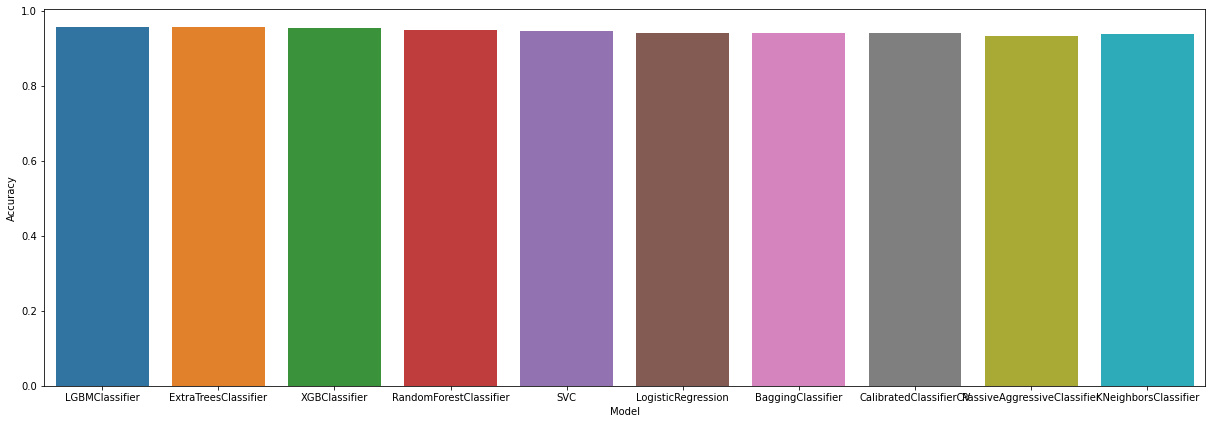

In [85]:
plt.figure(figsize=(17,6))
sns.barplot(x = models[0:10].index, y = models[0:10].Accuracy);
plt.tight_layout()

Binary Classification with all values

In [86]:
X = df.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass'])
y = df['bioactivity_binary_class']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [88]:
print(f'Null model accuracy: {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

Null model accuracy: 0.61


In [89]:
clf = Classification()

In [90]:
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [02:44<00:00,  5.68s/it]


In [91]:
models[0:8] #performs about the same as without intermediate values
       #considering the null value is 8% lower

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.91,0.90,0.90,0.91,2.60
RandomForestClassifier,0.91,0.89,0.89,0.91,2.25
XGBClassifier,0.90,0.89,0.89,0.90,10.24
LGBMClassifier,0.90,0.88,0.88,0.90,3.27
KNeighborsClassifier,0.90,0.88,0.88,0.90,12.59
SVC,0.90,0.88,0.88,0.90,27.26
BaggingClassifier,0.89,0.87,0.87,0.89,4.99
NuSVC,0.88,0.85,0.85,0.88,28.14


Multiclass Classification with all values

In [92]:
df['bioactivity_multiclass'].replace(to_replace = 'inactive',
                                    value = 0, inplace=True)

df['bioactivity_multiclass'].replace(to_replace = 'intermediate',
                                    value = 1, inplace=True)

df['bioactivity_multiclass'].replace(to_replace = 'active',
                                    value = 2, inplace=True)

In [93]:
X = df.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass'])
y = df['bioactivity_multiclass']

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [95]:
clf = Classification()

In [96]:
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [04:55<00:00, 10.19s/it]


In [97]:
models[0:5] #would need to adjust the classes and create separation

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.83,0.83,None,0.83,2.39
ExtraTreesClassifier,0.83,0.83,None,0.83,2.77
SVC,0.83,0.82,None,0.83,37.71
LGBMClassifier,0.82,0.82,None,0.82,7.34
KNeighborsClassifier,0.82,0.81,None,0.82,12.36


#### Regression Search

Regression predicting standard value with no intermediate values

In [98]:
X = df_small.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass'])
y = df_small['standard_value']

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [100]:
null_y = np.full_like(y_train, y.mean())
print(f'Null y MSE: {mean_squared_error(y_train, null_y)}')

Null y MSE: 116074227804.5209


In [101]:
rgr = Regression()

In [102]:
models, predictions = rgr.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [12:23<00:00, 17.71s/it] 


In [103]:
models[0:8]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LinearRegression,1032949232203942016.00,-2097939725672703744.00,513537289727364.00,2.43
TransformedTargetRegressor,1032949232203942016.00,-2097939725672703744.00,513537289727364.00,2.48
SGDRegressor,119142231984.65,-241980160970.22,174407582399.12,0.94
Lasso,4.01,-5.11,876706.04,4.65
KernelRidge,3.17,-3.41,744501.22,0.71
Ridge,3.13,-3.32,737312.22,0.62
RidgeCV,1.81,-0.64,454202.76,1.92
PoissonRegressor,1.76,-0.54,439933.93,0.66


Regression search predicting standard value with all values

In [104]:
X = df.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass'])
y = df['standard_value']

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [106]:
null_y = np.full_like(y_train, y.mean())
print(f'Null y MSE: {mean_squared_error(y_train, null_y)}')

Null y MSE: 76553896510.19798


In [107]:
rgr = Regression()

In [108]:
models, predictions = rgr.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [17:54<00:00, 25.59s/it]


In [111]:
len(models)

42

In [112]:
models.sort_values('R-Squared', ascending = False)[0:15]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LGBMRegressor,1.16,0.84,117916.97,2.71
HistGradientBoostingRegressor,1.16,0.84,118183.33,23.08
AdaBoostRegressor,1.18,0.83,123268.32,9.02
XGBRegressor,1.19,0.82,126485.34,10.06
ExtraTreesRegressor,1.20,0.80,131247.23,129.85
KNeighborsRegressor,1.21,0.79,135076.66,12.58
RandomForestRegressor,1.22,0.78,138686.16,91.66
GradientBoostingRegressor,1.26,0.74,149329.18,7.99
ExtraTreeRegressor,1.29,0.71,158747.64,1.74


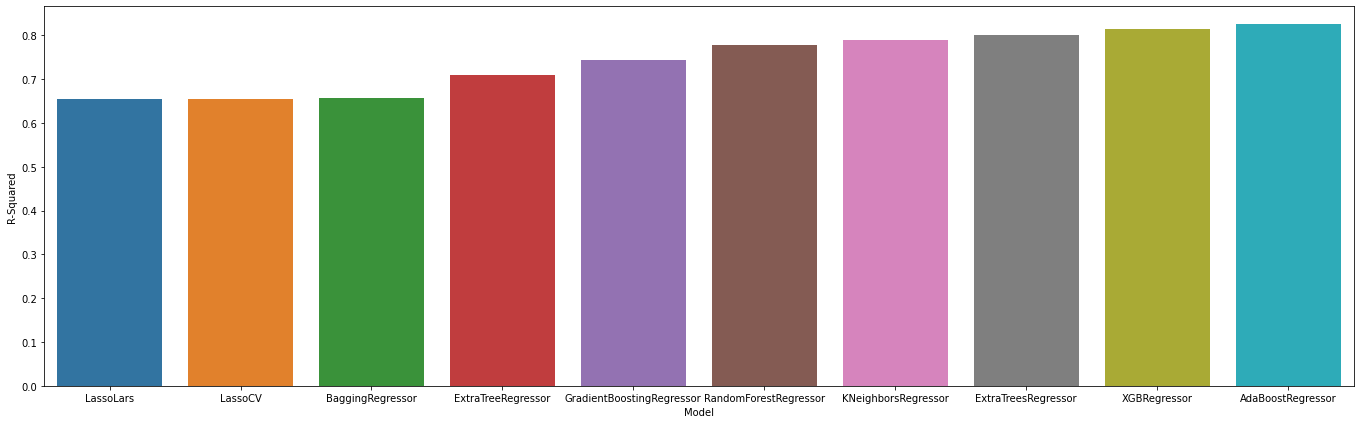

In [113]:
plt.figure(figsize=(19,6))
sns.barplot(x = models[30:40].index, y = models[30:40]['R-Squared']);
plt.tight_layout()

Regression predicting standard value with all values for comparison to search

In [114]:
X = df.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass'])
y = df['standard_value']

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [116]:
null_y = np.full_like(y_train, y.mean())
print(f'Null y MSE: {mean_squared_error(y_train, null_y)}')

Null y MSE: 69199559953.71716


In [117]:
rfr = RandomForestRegressor()

In [118]:
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [119]:
y_pred = rfr.predict(X_test)

In [120]:
def regression_eval(y_test, y_pred):
    print(f'MSE = {np.round(mean_squared_error(y_test, y_pred), 3)}')
    print(f'RMSE = {np.round(mean_squared_error(y_test, y_pred, squared = False), 3)}')
    print(f'MAE = {np.round(mean_absolute_error(y_test, y_pred), 3)}')
    print(f'r^2  = {np.round(r2_score(y_test, y_pred), 3)}')

In [121]:
regression_eval(y_test, y_pred)

MSE = 18869117445.515
RMSE = 137364.906
MAE = 34507.697
r^2  = 0.827


Standardizing target with log value of y

In [122]:
X = df.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass'])
y = df['standard_value']

In [123]:
y_std = y.map(lambda x: -np.log10(x * (10**-9)))

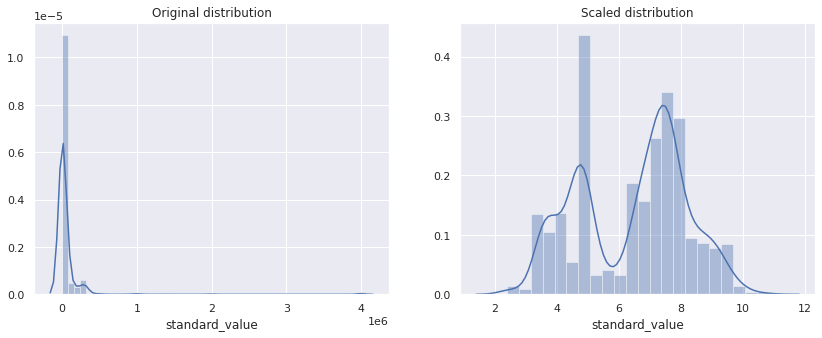

In [124]:
sns.set(style = 'darkgrid', context = 'notebook')
fig, ax = plt.subplots(1, 2, figsize = (14,5))

sns.distplot(df.standard_value, ax = ax[0]).set_title('Original distribution'); 
sns.distplot(y_std, ax = ax[1]).set_title('Scaled distribution');

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y_std)

In [126]:
null_y = np.full_like(y_train, y_std.mean())
print(f'Null y MSE: {mean_squared_error(y_train, null_y)}')

Null y MSE: 3.05674991172864


In [127]:
rfr = RandomForestRegressor()

In [128]:
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [129]:
y_pred = rfr.predict(X_test)

In [130]:
regression_eval(y_test, y_pred)

MSE = 0.74
RMSE = 0.86
MAE = 0.616
r^2  = 0.757


Regression with all values and variance threshold

In [28]:
#faster and slightly better results, but not sure if it will work with feature extraction

In [131]:
X = df.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass'])
y = df['standard_value']

In [132]:
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)
X.shape

(4137, 35)

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [134]:
null_y = np.full_like(y_train, y.mean())
print(f'Null y MSE: {mean_squared_error(y_train, null_y)}')

Null y MSE: 76333800567.52661


In [135]:
rfr = RandomForestRegressor()

In [136]:
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [137]:
y_pred = rfr.predict(X_test)

In [138]:
def regression_eval(y_test, y_pred):
    print(f'MSE = {np.round(mean_squared_error(y_test, y_pred), 3)}')
    print(f'RMSE = {np.round(mean_squared_error(y_test, y_pred, squared = False), 3)}')
    print(f'MAE = {np.round(mean_absolute_error(y_test, y_pred), 3)}')
    print(f'r^2  = {np.round(r2_score(y_test, y_pred), 3)}')

In [139]:
regression_eval(y_test, y_pred)

MSE = 41415334021.682
RMSE = 203507.577
MAE = 47060.499
r^2  = 0.527


### Drug Discovery Modeling

Import Libraries

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score,\
                            precision_score, recall_score, roc_auc_score,\
                            mean_squared_error, mean_absolute_error, r2_score,\
                            plot_confusion_matrix, classification_report, \
                            plot_roc_curve, f1_score
from sklearn.feature_selection import VarianceThreshold
from sklearn import set_config

from tqdm.notebook import tqdm

Data Import and Preparation

In [141]:
df = pd.read_csv('acinetobacter_baumannii_MIC_addFeats_addBits.csv').drop(columns = 'Unnamed: 0')

In [142]:
df.sample(3)

,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass,mol_wt,log_p,proton_donors,proton_acceptors,Bit_0,...,Bit_2038,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047
4807,COC(=O)Cc1ccc(/C=C/c2nc3ccccc3c(=O)n2-c2cccc(C...,16.00,active,1,active,440.45,3.97,1.00,6.00,0,...,0,0,1,0,0,0,0,0,0,0
5675,CCCCCc1ccc(C(=O)NCCn2cc(CCCCCc3cnc(N)n3Cc3ccc(...,1.00,active,1,active,583.83,6.57,2.00,7.00,1,...,0,0,0,0,0,1,0,0,0,0
1697,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O,128.00,inactive,0,intermediate,331.35,1.58,2.00,5.00,0,...,0,0,0,0,0,0,0,0,0,0


Creating a scaled target

In [143]:
df['pMIC'] = df['standard_value'].map(lambda x: -np.log10(x * (10**-9)))

In [144]:
#first test with subset not containing intermediate efficacy
df_bin_class = df[df.bioactivity_multiclass != 'intermediate']

In [145]:
df_bin_class.bioactivity_multiclass.value_counts()

active      3633
inactive    2564
Name: bioactivity_multiclass, dtype: int64

Scaling distribution:

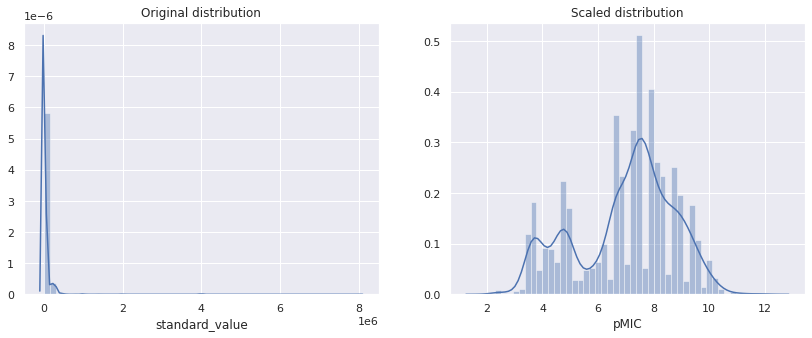

In [146]:
sns.set(style = 'darkgrid', context = 'notebook')
fig, ax = plt.subplots(1, 2, figsize = (14,5))

sns.distplot(df.standard_value, ax = ax[0]).set_title('Original distribution'); 
sns.distplot(df.pMIC, ax = ax[1]).set_title('Scaled distribution');

Testing progress bar function

In [147]:
from tqdm.notebook import tqdm_notebook
import time

example_iter = [1,2,3,4,5]
for rec in tqdm_notebook(example_iter):
    time.sleep(.1)

  0%|          | 0/5 [00:00<?, ?it/s]

#### Hyperparameter Searching

##### Regression

<i>Scaled distribution</i>

In [148]:
def regression_eval(y, y_train, y_test, y_pred):
    """
    """
    null_y = np.full_like(y_train, y.mean())
        
    print(' __________________ ')
    print(f'|Null MSE = {np.round(mean_squared_error(y_train, null_y), 3)}  |')
    print('|------------------|')
    print(f'|   MSE   = {np.round(mean_squared_error(y_test, y_pred), 3)}  |')
    print('|------------------|')
    print(f'|   RMSE  = {np.round(mean_squared_error(y_test, y_pred, squared = False), 3)}  |')
    print('|------------------|')
    print(f'|   MAE   = {np.round(mean_absolute_error(y_test, y_pred), 3)}  |')
    print('|------------------|')
    print(f'|   r^2   = {np.round(r2_score(y_test, y_pred), 3)}  |')
    print(' ------------------ ')

In [149]:
X = df.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass', 'pMIC'])
y = df['pMIC']

In [150]:
ss = StandardScaler()
num_cols = ['mol_wt', 'log_p', 'proton_donors', 'proton_acceptors']
X[num_cols] = ss.fit_transform(X[num_cols])

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Testing progress bar function and exploring `n_estimators`

In [152]:
parameter_n_estimators = [100,500,1000]

for i in tqdm(parameter_n_estimators):
  model = RandomForestRegressor(n_estimators=i)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  regression_eval(y, y_train, y_test, y_pred)

  0%|          | 0/3 [00:00<?, ?it/s]

 __________________ 
|Null MSE = 3.125  |
|------------------|
|   MSE   = 0.847  |
|------------------|
|   RMSE  = 0.92  |
|------------------|
|   MAE   = 0.645  |
|------------------|
|   r^2   = 0.716  |
 ------------------ 
 __________________ 
|Null MSE = 3.125  |
|------------------|
|   MSE   = 0.844  |
|------------------|
|   RMSE  = 0.919  |
|------------------|
|   MAE   = 0.641  |
|------------------|
|   r^2   = 0.716  |
 ------------------ 
 __________________ 
|Null MSE = 3.125  |
|------------------|
|   MSE   = 0.846  |
|------------------|
|   RMSE  = 0.92  |
|------------------|
|   MAE   = 0.642  |
|------------------|
|   r^2   = 0.716  |
 ------------------ 


In [153]:
RFR = RandomForestRegressor()
#ss = StandardScaler()

In [154]:
#pipe = make_pipeline(ss, RFR)

In [155]:
RFR_params = {
    'ccp_alpha': [0, 0.0001, 3],
    #'randomforestregressor__oob_score': [True, False], 
    'n_estimators': [100] #increasing n_estimators did not benefit
}

In [156]:
grid_rfr = GridSearchCV(RFR, RFR_params, verbose = 3, n_jobs = -1)

In [157]:
%%time
grid_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  8.0min finished


CPU times: user 1min 29s, sys: 688 ms, total: 1min 30s
Wall time: 9min 31s


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'ccp_alpha': [0, 0.0001, 3], 'n_estimators': [100]},
             verbose=3)

In [158]:
y_pred = grid_rfr.predict(X_test)

In [159]:
regression_eval(y, y_train, y_test, y_pred)

 __________________ 
|Null MSE = 3.125  |
|------------------|
|   MSE   = 0.854  |
|------------------|
|   RMSE  = 0.924  |
|------------------|
|   MAE   = 0.647  |
|------------------|
|   r^2   = 0.713  |
 ------------------ 


In [160]:
grid_rfr.best_params_

{'ccp_alpha': 0.0001, 'n_estimators': 100}

Percent improvement over null model:

In [161]:
null_y = np.full_like(y_train, y.mean())

null_MSE = np.round(mean_squared_error(y_train, null_y), 3)
MSE = np.round(mean_squared_error(y_test, y_pred), 3)

print(f'Percent improvement = {(np.abs(np.round(((null_MSE - MSE) / null_MSE), 3)))*100}%')

Percent improvement = 72.7%


<i>Original distribution</i>

In [162]:
X = df.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass', 'pMIC'])
y = df['standard_value']

In [163]:
ss = StandardScaler()
num_cols = ['mol_wt', 'log_p', 'proton_donors', 'proton_acceptors']
X[num_cols] = ss.fit_transform(X[num_cols])

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [165]:
RFR = RandomForestRegressor()
#ss = StandardScaler()

In [166]:
#pipe = make_pipeline(ss, RFR)

In [167]:
RFR_params = {
    'ccp_alpha': [0, 0.001, 2],
    #'randomforestregressor__oob_score': [True, False], 
    'n_estimators': [200]
}

In [168]:
grid_rfr_2 = GridSearchCV(RFR, RFR_params, verbose = 3, n_jobs = -1)

In [169]:
%%time
grid_rfr_2.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 39.4min finished


CPU times: user 7min 26s, sys: 182 ms, total: 7min 26s
Wall time: 46min 48s


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'ccp_alpha': [0, 0.001, 2], 'n_estimators': [200]},
             verbose=3)

In [170]:
y_pred_2 = grid_rfr_2.predict(X_test)

In [171]:
regression_eval(y, y_train, y_test, y_pred_2)

 __________________ 
|Null MSE = 51228921826.589  |
|------------------|
|   MSE   = 3736870404.034  |
|------------------|
|   RMSE  = 61129.947  |
|------------------|
|   MAE   = 17594.555  |
|------------------|
|   r^2   = 0.862  |
 ------------------ 


Percent improvement over null model:

In [172]:
null_y = np.full_like(y_train, y.mean())

null_MSE = np.round(mean_squared_error(y_train, null_y), 3)
MSE = np.round(mean_squared_error(y_test, y_pred_2), 3)

print(f'Percent improvement = {(np.abs(np.round(((null_MSE - MSE) / null_MSE), 3)))*100}%')

Percent improvement = 92.7%


Standardized target ~3% lower MSE

#### Classification

In [173]:
def classification_eval(y_test, y_pred):
    """
    """
    #print(f'null accuracy = {np.round(max(y_test.mean(), 1 - y_test.mean()), 3)}')
    print(f'    accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'    precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'    recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'    f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'    roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')

In [174]:
X = df_bin_class.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass', 'pMIC'])
y = df_bin_class['bioactivity_binary_class']

In [175]:
ss = StandardScaler()
num_cols = ['mol_wt', 'log_p', 'proton_donors', 'proton_acceptors']
X[num_cols] = ss.fit_transform(X[num_cols])

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [177]:
RFC_params = {
#     'randomforestclassifier__n_estimators' : [100],
#     'randomforestclassifier__ccp_alpha' : [0.0, 0.01, 1, 3],
#     'randomforestclassifier__min_samples_leaf' : [0, 1, 4],
#     'randomforestclassifier__criterion' : ['gini', 'entropy']
    'n_estimators' : [100],
    'ccp_alpha' : [0.0, 0.01, 1, 3],
    'min_samples_leaf' : [0, 1, 4],
    'criterion' : ['gini', 'entropy']
}

In [178]:
RFC = RandomForestClassifier()
#ss = StandardScaler()

In [179]:
#pipe_class = make_pipeline(ss, RFC)

In [180]:
grid_rfc = GridSearchCV(RFC, RFC_params, verbose = 3)

In [181]:
%%time
grid_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] ccp_alpha=0.0, criterion=gini, min_samples_leaf=0, n_estimators=100 
[CV]  ccp_alpha=0.0, criterion=gini, min_samples_leaf=0, n_estimators=100, score=nan, total=   0.1s
[CV] ccp_alpha=0.0, criterion=gini, min_samples_leaf=0, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  ccp_alpha=0.0, criterion=gini, min_samples_leaf=0, n_estimators=100, score=nan, total=   0.1s
[CV] ccp_alpha=0.0, criterion=gini, min_samples_leaf=0, n_estimators=100 
[CV]  ccp_alpha=0.0, criterion=gini, min_samples_leaf=0, n_estimators=100, score=nan, total=   0.1s
[CV] ccp_alpha=0.0, criterion=gini, min_samples_leaf=0, n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  ccp_alpha=0.0, criterion=gini, min_samples_leaf=0, n_estimators=100, score=nan, total=   0.1s
[CV] ccp_alpha=0.0, criterion=gini, min_samples_leaf=0, n_estimators=100 
[CV]  ccp_alpha=0.0, criterion=gini, min_samples_leaf=0, n_estimators=100, score=nan, total=   0.1s
[CV] ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, n_estimators=100 
[CV]  ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, n_estimators=100, score=0.947, total=   2.6s
[CV] ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, n_estimators=100 
[CV]  ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, n_estimators=100, score=0.960, total=   2.6s
[CV] ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, n_estimators=100 
[CV]  ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, n_estimators=100, score=0.953, total=   2.6s
[CV] ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, n_estimators=100 
[CV]  ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, n_estimators=100, score=0.942, total=   2.7s
[CV] ccp_alpha=0.0, cr

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  3.0min finished


CPU times: user 3min 5s, sys: 226 ms, total: 3min 5s
Wall time: 3min 5s


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'ccp_alpha': [0.0, 0.01, 1, 3],
                         'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [0, 1, 4], 'n_estimators': [100]},
             verbose=3)

In [182]:
y_preds = grid_rfc.predict(X_test)

In [183]:
grid_rfc.score(X_train, y_train), grid_rfc.score(X_test, y_test)

(0.9685818807833011, 0.9329032258064516)

In [184]:
classification_eval(y_test, y_preds)

    accuracy  = 0.933
    precision = 0.921
    recall    = 0.966
    f1-score  = 0.943
    roc auc   = 0.927


In [185]:
grid_rfc.best_params_

{'ccp_alpha': 0.0,
 'criterion': 'gini',
 'min_samples_leaf': 1,
 'n_estimators': 100}

#### Final Models

Regression with Standardized Target

In [186]:
def regression_and_eval(X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    null_y = np.full_like(y_train, y.mean())
    model = model
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(' __________________ ')
    print(f'|Null MSE = {np.round(mean_squared_error(y_train, null_y), 3)}  |')
    print('|------------------|')
    print(f'|   MSE   = {np.round(mean_squared_error(y_test, y_pred), 3)}  |')
    print('|------------------|')
    print(f'|   RMSE  = {np.round(mean_squared_error(y_test, y_pred, squared = False), 3)}  |')
    print('|------------------|')
    print(f'|   MAE   = {np.round(mean_absolute_error(y_test, y_pred), 3)}  |')
    print('|------------------|')
    print(f'|   r^2   = {np.round(r2_score(y_test, y_pred), 3)}  |')
    print(' ------------------ ')
    
    return model

Binary Classification

In [187]:
def classification_and_eval(X, y, model, params):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    model = model
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f'null accuracy = {round(max(y_test.mean(), 1 - y_test.mean()), 3)}')
    print(f'    accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'    precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'    recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'    f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'    roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')
    
    return model

### Drug Discovery Model Evaluation and Feature Extraction

Import Libraries

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn import set_config
from sklearn import tree

from dtreeviz.trees import dtreeviz, explain_prediction_path

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

from sklearn.inspection import permutation_importance

from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [208]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, ExtraTreesRegressor

Data Import and Preparation

In [190]:
df = pd.read_csv('acinetobacter_baumannii_MIC_addFeats_addBits.csv').drop(columns = 
                        'Unnamed: 0').drop_duplicates(subset = ['canonical_smiles'])

In [191]:
df.shape

(4137, 2057)

In [192]:
df.sample(3)

,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass,mol_wt,log_p,proton_donors,proton_acceptors,Bit_0,...,Bit_2038,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047
8028,Cc1cc(C)c(N(C(=O)c2sc(C)nc2C)C(C(=O)NC2CCCCC2)...,50000.00,inactive,0,inactive,489.69,6.52,1.00,4.00,0,...,0,0,0,0,0,0,0,0,0,0
4411,O=C1COc2ccc(CNC34CCC(CCc5c(F)cnc6ccc(OCC(CO)CO...,8.00,active,1,active,567.62,2.28,4.00,10.00,0,...,0,0,0,0,0,0,0,0,0,0
7544,C#Cc1cccc(/N=C/c2cc(O)ccc2[N+](=O)[O-])c1,256.00,inactive,0,intermediate,266.26,3.03,1.00,4.00,0,...,0,0,0,0,0,0,0,0,0,0


Creating a scaled target

In [193]:
df['pMIC'] = df['standard_value'].map(lambda x: -np.log10(x * (10**-9)))

#### Model Evaluation

##### Regression
* Scaled distribution
* Parameters determined in prior notebook using `GridSearchCV`

In [194]:
X_r = df.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass', 'pMIC'])
y_r = df['pMIC']

In [195]:
ss = StandardScaler()
num_cols = ['mol_wt', 'log_p', 'proton_donors', 'proton_acceptors']
X_r[num_cols] = ss.fit_transform(X_r[num_cols])

In [196]:
def regression_and_eval(X, y, model):
    """
    Takes in x and y variables, and fits a regression model.
    
    Args: X, y, model
    
    Returns: trained model, X_train, X_test, y_train, y_test, y_pred
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 19)
    null_y = np.full_like(y_train, y.mean())
    model = model
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    null_MSE = mean_squared_error(y_train, null_y)
    MSE = mean_squared_error(y_test, y_pred)

    print(' __________________ ')
    print(f'|Null MSE = {np.round(mean_squared_error(y_train, null_y), 3)}  |')
    print('|------------------|')
    print(f'|   MSE   = {np.round(mean_squared_error(y_test, y_pred), 3)}  |')
    print('|------------------|')
    print(f'|   RMSE  = {np.round(mean_squared_error(y_test, y_pred, squared = False), 3)}  |')
    print('|------------------|')
    print(f'|   MAE   = {np.round(mean_absolute_error(y_test, y_pred), 3)}  |')
    print('|------------------|')
    print(f'|   r^2   = {np.round(r2_score(y_test, y_pred), 3)}  |')
    print(' ------------------ ')
    print(f'MSE% greater than null = {(np.abs(np.round(((null_MSE - MSE) / null_MSE), 3)))*100}%') 
    
    return model, X_train, X_test, y_train, y_test, y_pred

In [209]:
r_model, X_train_r, X_test_r, y_train_r, y_test_r, y_pred_r = regression_and_eval(X_r, y_r, 
                                                            ExtraTreesRegressor(n_estimators = 800, 
                                                                                n_jobs = -1))

 __________________ 
|Null MSE = 3.088  |
|------------------|
|   MSE   = 0.958  |
|------------------|
|   RMSE  = 0.979  |
|------------------|
|   MAE   = 0.581  |
|------------------|
|   r^2   = 0.675  |
 ------------------ 
MSE% greater than null = 69.0%


In [198]:
rf_model, X_train_rf, X_test_rf, y_train_rf, y_test_rf, y_pred_rf = regression_and_eval(X_r, y_r, 
                                                        RandomForestRegressor(n_jobs = -1, 
                                                                              #verbose = 1,
                                                                    #min_samples_leaf = 3,
                                                                       n_estimators = 100,
                                                                       warm_start = True))

 __________________ 
|Null MSE = 3.088  |
|------------------|
|   MSE   = 0.751  |
|------------------|
|   RMSE  = 0.866  |
|------------------|
|   MAE   = 0.601  |
|------------------|
|   r^2   = 0.746  |
 ------------------ 
MSE% greater than null = 75.7%


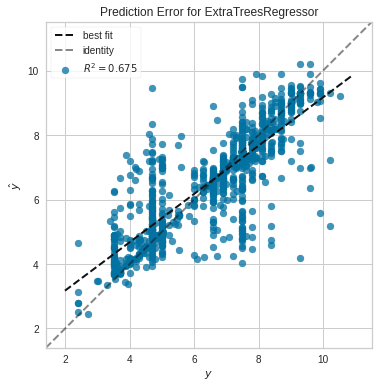

In [210]:
from yellowbrick.regressor import PredictionError

plt.figure(figsize=(12,6))

visualizer = PredictionError(r_model)
visualizer.fit(X_train_r, y_train_r)  

visualizer.score(X_test_r, y_test_r)  
visualizer.show()

#### Feature Importance

In [211]:
feature_import_df = pd.DataFrame(r_model.feature_importances_, 
                                   index =X_r.columns,  
                                   columns=['importance']).sort_values('importance', 
                                                                       ascending=False)

In [212]:
feature_import_df.head(15)

,importance
Bit_314,0.10
Bit_2021,0.05
Bit_309,0.04
Bit_935,0.03
Bit_1047,0.02
Bit_1602,0.02
Bit_1866,0.02
Bit_1731,0.01
mol_wt,0.01
Bit_506,0.01


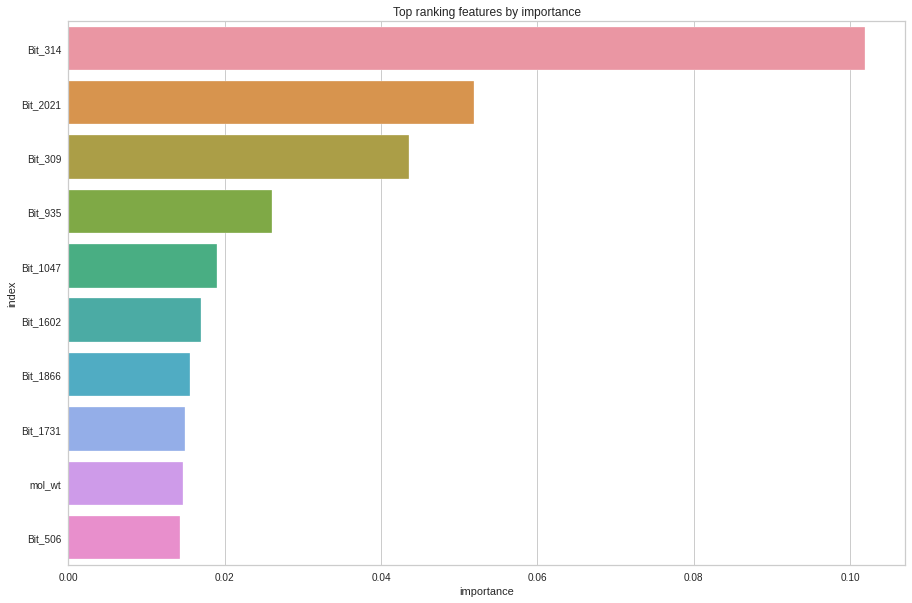

In [213]:
graph_feat_importance = feature_import_df.reset_index(col_fill = 'feature')

plt.figure(figsize=(15, 10))
x = graph_feat_importance['importance'].head(10)
y = graph_feat_importance['index'].head(10)
sns.barplot(x = x, y = y).set_title('Top ranking features by importance');

#### Residuals and Outliers

In [214]:
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import CooksDistance

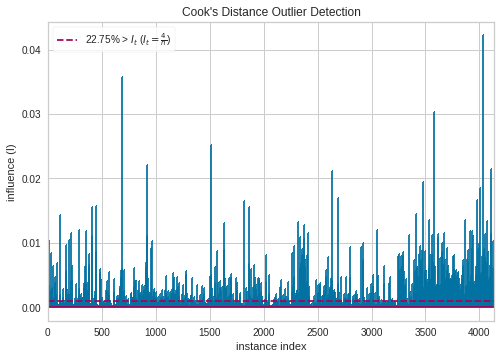

In [215]:
visualizer = CooksDistance()
visualizer.fit(X_r, y_r)
visualizer.show();

In [216]:
residuals_as_percent_diff = np.abs((y_test_r - y_pred_r) / y_test_r)

In [217]:
residuals = y_test_r - y_pred_r
residuals[0:4]

5279   -0.48
3850    0.56
7959    0.25
1472   -1.98
Name: pMIC, dtype: float64

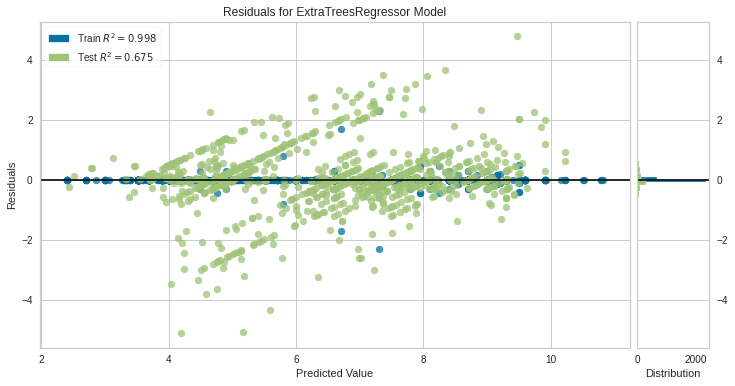

In [220]:
plt.figure(figsize=(12,6))
visualizer = ResidualsPlot(r_model, hist=True, qqplot=False)
visualizer.fit(X_train_r, y_train_r)
visualizer.score(X_test_r, y_test_r)
visualizer.show();

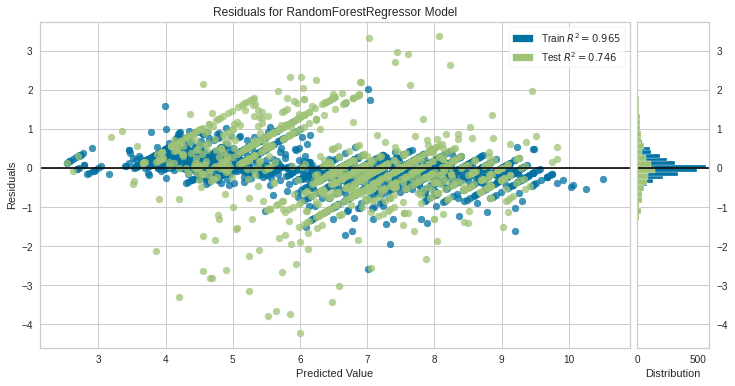

In [219]:
plt.figure(figsize=(12,6))
visualizer = ResidualsPlot(rf_model, hist=True, qqplot=False)
visualizer.fit(X_train_rf, y_train_rf)
visualizer.score(X_test_rf, y_test_rf)
visualizer.show();

In [221]:
residuals_df = pd.concat([residuals_as_percent_diff, 
                          df['canonical_smiles']], axis = 1).dropna()

The molecules the model had the most difficulty determining bioactivity for:

In [222]:
# less extreme residuals with HistGradient vs Random Forest
# would be useful to look at what molecules each 
# model excels at
residuals_df.sort_values('pMIC', ascending = False).head(10)

,pMIC,canonical_smiles
8756,1.01,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNC(C)C3)c(F)c2...
5734,0.94,Cc1nonc1NC(=O)CSc1ccc2ccccc2c1
7711,0.89,CC1(c2ccc(C#N)cc2)NC(=O)N(CC(=O)c2ccc(F)cc2F)C1=O
5425,0.81,O=C(O)c1ccccc1NC=C1C(=O)N(c2ccccc2)C(=S)N(c2cc...
7032,0.80,CC[C@H](O)CCC(C1=C(O)[C@@H](C)OC1=O)C1=C(O)[C@...
8564,0.78,CN1CCCN(c2nc3ccccc3cc2CO)CC1
8737,0.78,CC(C)CCN1C(=O)C(C2=NS(=O)(=O)c3cc(NS(C)(=O)=O)...
8552,0.77,NCCNC(=O)c1ccc(-c2ccc(Cl)cc2)s1
5832,0.75,CC(=O)OCC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)C(NC(=...
3583,0.69,Clc1ccc(-c2cc3ccccc3[nH]2)cc1


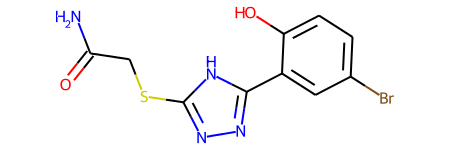

In [223]:
Chem.MolFromSmiles(df.canonical_smiles[8727])

Exploring Bits for Top Residuals

In [224]:
mol = Chem.MolFromSmiles(residuals_df.canonical_smiles[8727])

In [225]:
bi = {}
vect = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
# show 10 of the set bits:
list(vect.GetOnBits())[:10]

[80, 116, 140, 341, 352, 378, 650, 678, 694, 728]

In [226]:
# from http://rdkit.blogspot.com/2018/10/using-new-fingerprint-bit-rendering-code.html
from ipywidgets import interact, fixed, IntSlider

def renderFpBit(mol, bitIdx, bitInfo, fn):
    bid = bitIdx
    
    return(display(fn(mol,bid,bitInfo)))

In [227]:
# can scroll through the bits that make up the molecules
interact(renderFpBit, bitIdx=list(bi.keys()),mol=fixed(mol),
         bitInfo=fixed(bi),fn=fixed(Draw.DrawMorganBit));
# may not push to GitHub

interactive(children=(Dropdown(description='bitIdx', options=(80, 116, 140, 341, 352, 378, 650, 678, 694, 728,…

### Drug Discovery Model Evaluation and Feature Extraction

Import Libraries

In [228]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score,\
                            precision_score, recall_score, roc_auc_score,\
                            mean_squared_error, mean_absolute_error, r2_score,\
                            plot_confusion_matrix, classification_report, \
                            plot_roc_curve, f1_score
from sklearn.feature_selection import VarianceThreshold
from sklearn import set_config
from sklearn import tree

from dtreeviz.trees import dtreeviz, explain_prediction_path

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

from sklearn.inspection import permutation_importance

from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier

##### Data Import and Preparation

In [229]:
df = pd.read_csv('acinetobacter_baumannii_MIC_addFeats_addBits.csv').drop(columns = 
                                'Unnamed: 0').drop_duplicates(subset = ['canonical_smiles'])

In [230]:
df.shape

(4137, 2057)

In [231]:
df.sample(3)

,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass,mol_wt,log_p,proton_donors,proton_acceptors,Bit_0,...,Bit_2038,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047
4481,CC(CN)CNC[C@H](O)C[C@@H](N)CC(=O)NN(C)CC(=O)O,16.00,active,1,active,319.41,-2.31,6.00,7.00,0,...,1,0,0,0,0,0,0,0,0,0
8031,Cc1nc(C)c(C(=O)N(c2cccc(C)c2C)C(C(=O)NCc2ccccc...,50000.00,inactive,0,inactive,483.64,6.08,1.00,4.00,0,...,0,0,0,0,0,0,0,0,0,0
4288,O=C1COc2cnc(CNC34CCC(C[C@]5(O)Cn6c(=O)ccc7ncc(...,32.00,active,1,intermediate,508.51,1.12,3.00,10.00,0,...,0,0,0,0,0,0,0,0,0,0


Creating a scaled target

In [232]:
df['pMIC'] = df['standard_value'].map(lambda x: -np.log10(x * (10**-9)))

In [233]:
#first test with subset not containing intermediate efficacy
df_bin_class = df[df.bioactivity_multiclass != 'intermediate']

In [234]:
df_bin_class.bioactivity_multiclass.value_counts()

inactive    1618
active      1092
Name: bioactivity_multiclass, dtype: int64

#### Model Evaluation

##### Classification

In [235]:
X_c = df_bin_class.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass', 'pMIC'])
y_c = df_bin_class['bioactivity_binary_class']

In [236]:
ss = StandardScaler()
num_cols = ['mol_wt', 'log_p', 'proton_donors', 'proton_acceptors']
X_c[num_cols] = ss.fit_transform(X_c[num_cols])

In [237]:
def classification_and_eval(X, y, model):
    """
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    model = model
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f'null accuracy = {round(max(y_test.mean(), 1 - y_test.mean()), 3)}')
    print(f'    accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'    precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'    recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'    f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'    roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')
    
    return model, X_test, y_test, y_pred

In [238]:
c_model, X_test_c, y_test_c, y_pred_c = classification_and_eval(X_c, y_c, 
                                        ExtraTreesClassifier(n_estimators = 800,
                                                             n_jobs = -1, 
                                                             verbose = 0))

null accuracy = 0.618
    accuracy  = 0.963
    precision = 0.988
    recall    = 0.915
    f1-score  = 0.95
    roc auc   = 0.954


In [239]:
c_model, X_test_c, y_test_c, y_pred_c = classification_and_eval(X_c, y_c, 
                                        RandomForestClassifier(n_jobs = -1, 
                                                               verbose = 0))

null accuracy = 0.603
    accuracy  = 0.959
    precision = 0.973
    recall    = 0.922
    f1-score  = 0.947
    roc auc   = 0.952


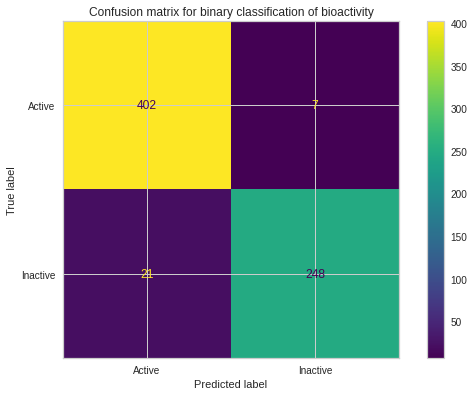

In [240]:
plot_confusion_matrix(c_model, X_test_c, y_test_c, display_labels = ['Active', 'Inactive']);
plt.tight_layout();
plt.title('Confusion matrix for binary classification of bioactivity');

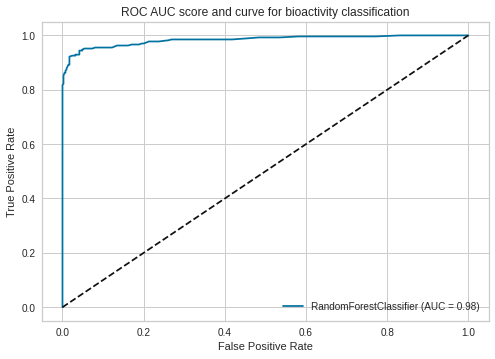

In [241]:
plot_roc_curve(c_model, X_test_c, y_test_c)
plt.title('ROC AUC score and curve for bioactivity classification');
plt.plot([0,1], [0,1], 'k--')
plt.show();

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


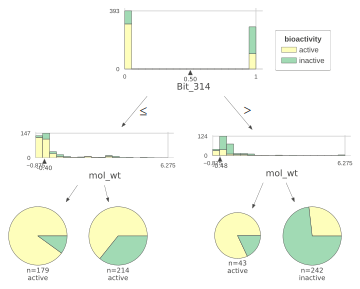

In [242]:
# https://github.com/parrt/dtreeviz
# not compatible with random forest
# much lower accuracy
X_train, X_test, y_train, y_test = train_test_split(X_c, y_c)
classifier = tree.DecisionTreeClassifier(max_depth=2)  # limit depth of tree
classifier.fit(X_train, y_train)

viz = dtreeviz(classifier, 
               X_test,
               y_test,
               target_name='bioactivity',
               feature_names = X_c.columns, 
               class_names=["active", "inactive"], 
               histtype= 'barstacked')  # barstackes is default
viz

#### Feature Importances

In [243]:
feature_import_df = pd.DataFrame(c_model.feature_importances_, 
                                   index =X_c.columns,  
                                   columns=['importance']).sort_values('importance', 
                                                                       ascending=False)

In [244]:
feature_import_df[0:15]

,importance
mol_wt,0.03
proton_donors,0.02
Bit_314,0.01
Bit_1602,0.01
log_p,0.01
proton_acceptors,0.01
Bit_351,0.01
Bit_456,0.01
Bit_1395,0.01
Bit_2021,0.01


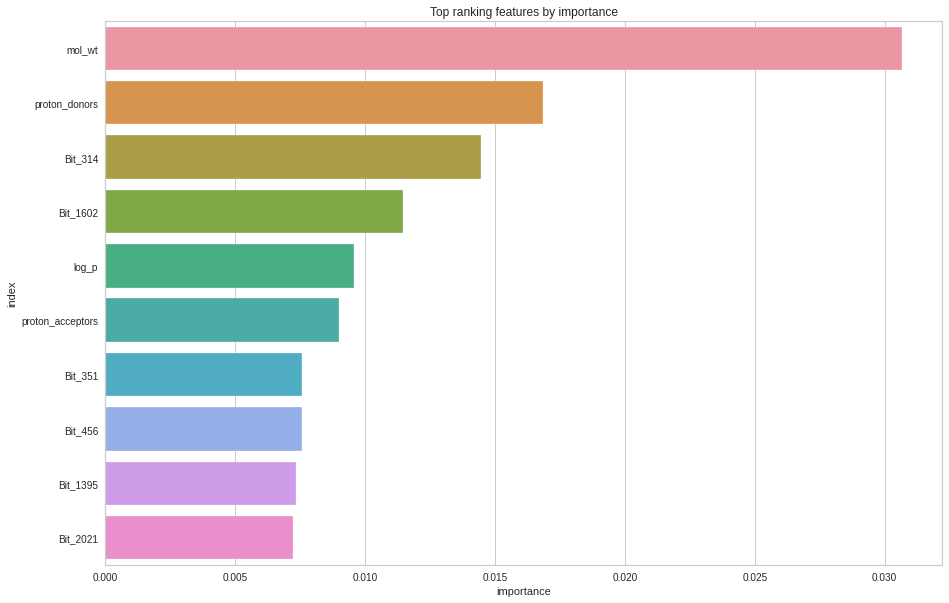

In [245]:
graph_feat_importance = feature_import_df.reset_index(col_fill = 'feature')

plt.figure(figsize=(15, 10))
x = graph_feat_importance['importance'].head(10)
y = graph_feat_importance['index'].head(10)
sns.barplot(x = x, y = y).set_title('Top ranking features by importance');

#### Feature Extraction

Bit 314

In [246]:
bit_314s = df[df.Bit_314 == 1]

In [247]:
bit_314s.shape

(1618, 2058)

In [248]:
bit_314s.sort_values(by = 'pMIC', ascending = False).head(3)

,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass,mol_wt,log_p,proton_donors,proton_acceptors,Bit_0,...,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047,pMIC
2475,N[C@@H]1CCCCN(c2c(F)cc3c(=O)c(C(=O)O)cn(C4CC4)...,0.01,active,1,active,393.85,3.14,2.00,5.00,1,...,0,0,0,0,0,0,0,0,0,10.82
3708,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,0.02,active,1,active,558.56,0.29,6.00,10.00,0,...,0,0,0,0,0,0,0,0,0,10.80
3710,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,0.02,active,1,active,544.54,-0.10,6.00,10.00,0,...,0,0,0,0,0,0,0,0,0,10.80


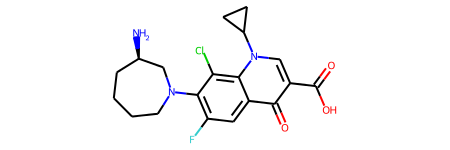

In [249]:
#mol_1 produces error
mol_1 = Chem.MolFromSmiles(bit_314s.canonical_smiles[2475]) 
mol_1

In [250]:
mol_2 = Chem.MolFromSmiles(bit_314s.canonical_smiles[3708])

In [251]:
bi = {}
vect = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol_2, radius=2, bitInfo=bi)
# show 10 of the set bits:
list(vect.GetOnBits())[:20]

[140,
 202,
 231,
 253,
 309,
 314,
 354,
 361,
 423,
 432,
 446,
 486,
 519,
 525,
 531,
 562,
 585,
 650,
 658,
 673]

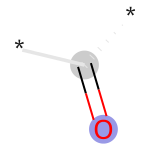

In [252]:
Draw.DrawMorganBit(mol_2, 314, bi)

In [253]:
# produces more errors than images
def bit_checker(mol, vect):
    for i in vect:
        try:
            [Draw.DrawMorganBit(mol, i, bi) for i in list(vect.GetOnBits())]
        except:
            pass
        
    return

In [254]:
bit_388s = df[df.Bit_388 == 1]

In [255]:
bit_388s.sort_values(by = 'pMIC', ascending = False).head(3)

,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass,mol_wt,log_p,proton_donors,proton_acceptors,Bit_0,...,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047,pMIC
5296,COc1ccc2ccc(F)c(C[C@H](N)[C@@H]3CC[C@@H](NCc4c...,0.03,active,1,active,481.53,2.32,3.00,8.00,0,...,0,0,0,0,0,0,0,0,0,10.52
5297,COc1ccc2ccc(=O)n(C[C@H](O)[C@@H]3CC[C@@H](NCc4...,0.03,active,1,active,481.51,0.83,3.00,10.00,0,...,0,0,0,0,0,0,0,0,0,10.52
3358,c1cc2cc(-c3ccc(-c4cc5ccc(C6=NCCN6)cc5[nH]4)cc3...,0.06,active,1,active,444.54,4.68,4.00,4.00,0,...,0,0,0,0,0,0,0,0,0,10.22


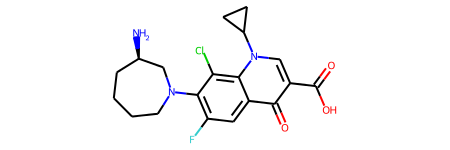

In [256]:
mol_1 = Chem.MolFromSmiles(bit_314s.canonical_smiles[2475]) 
mol_1

In [257]:
mol_2 = Chem.MolFromSmiles(bit_314s.canonical_smiles[3708])

In [258]:
bi = {}
vect = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol_2, radius=2, bitInfo=bi)
# show 10 of the set bits:
list(vect.GetOnBits())[:20]

[140,
 202,
 231,
 253,
 309,
 314,
 354,
 361,
 423,
 432,
 446,
 486,
 519,
 525,
 531,
 562,
 585,
 650,
 658,
 673]

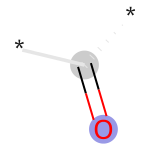

In [259]:
Draw.DrawMorganBit(mol_2, 314, bi)

Bit 388

In [260]:
bit_388s = df[df.Bit_388 == 1]

In [261]:
bit_388s.sort_values(by = 'pMIC', ascending = False).head(3)

,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass,mol_wt,log_p,proton_donors,proton_acceptors,Bit_0,...,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047,pMIC
5296,COc1ccc2ccc(F)c(C[C@H](N)[C@@H]3CC[C@@H](NCc4c...,0.03,active,1,active,481.53,2.32,3.00,8.00,0,...,0,0,0,0,0,0,0,0,0,10.52
5297,COc1ccc2ccc(=O)n(C[C@H](O)[C@@H]3CC[C@@H](NCc4...,0.03,active,1,active,481.51,0.83,3.00,10.00,0,...,0,0,0,0,0,0,0,0,0,10.52
3358,c1cc2cc(-c3ccc(-c4cc5ccc(C6=NCCN6)cc5[nH]4)cc3...,0.06,active,1,active,444.54,4.68,4.00,4.00,0,...,0,0,0,0,0,0,0,0,0,10.22


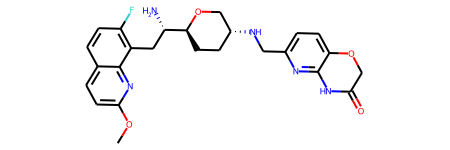

In [262]:
#mol_1 produces error
mol = Chem.MolFromSmiles(bit_314s.canonical_smiles[5296]) 
mol

In [263]:
bi = {}
vect = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
# show 10 of the set bits:
list(vect.GetOnBits())[:10]

[1, 9, 24, 79, 80, 118, 126, 203, 216, 255]

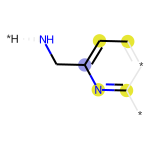

In [264]:
Draw.DrawMorganBit(mol, 388, bi)

Bit 1395

In [265]:
bit_1395s = df[df.Bit_1395 == 1]

In [266]:
bit_1395s.sort_values(by = 'pMIC', ascending = False).head(3)

,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass,mol_wt,log_p,proton_donors,proton_acceptors,Bit_0,...,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047,pMIC
3708,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,0.02,active,1,active,558.56,0.29,6.00,10.00,0,...,0,0,0,0,0,0,0,0,0,10.80
3710,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,0.02,active,1,active,544.54,-0.10,6.00,10.00,0,...,0,0,0,0,0,0,0,0,0,10.80
3686,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,0.03,active,1,active,558.56,0.29,6.00,10.00,0,...,0,0,0,0,0,0,0,0,0,10.51


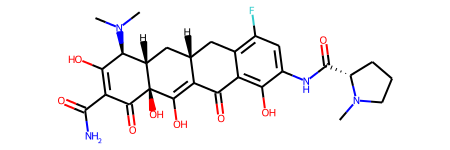

In [267]:
mol = Chem.MolFromSmiles(bit_1395s.canonical_smiles[3708]) 
mol

In [268]:
bi = {}
vect = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
# show 10 of the set bits:
list(vect.GetOnBits())[:10]

[140, 202, 231, 253, 309, 314, 354, 361, 423, 432]

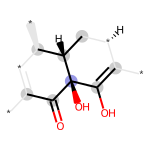

In [269]:
Draw.DrawMorganBit(mol, 1395, bi)

Bit 1608

In [270]:
bit_1608s = df[df.Bit_1608 == 1]

In [271]:
bit_1608s.sort_values(by = 'pMIC', ascending = False).head(3)

,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass,mol_wt,log_p,proton_donors,proton_acceptors,Bit_0,...,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047,pMIC
4422,NC1CC1COc1ccc2ncc(F)c(CCC34CCC(NCc5ccc6c(n5)NC...,0.25,active,1,active,548.62,3.03,3.00,9.00,0,...,0,0,0,0,0,0,0,0,0,9.60
4323,O=c1ccc2ncc(F)c3c2n1C[C@@]3(O)CC12CCC(NC/C=C/c...,0.25,active,1,active,497.52,3.79,2.00,6.00,0,...,0,0,0,0,0,0,0,0,0,9.60
4205,Cc1cc(=O)n2c3c(c(F)cnc13)[C@](O)(CC13CCC(NCc4c...,0.50,active,1,active,521.55,2.03,3.00,9.00,0,...,0,0,0,0,0,0,0,0,0,9.30


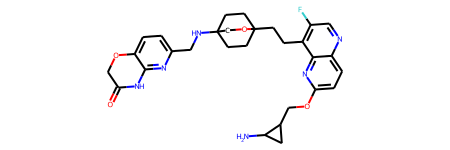

In [272]:
mol = Chem.MolFromSmiles(bit_1608s.canonical_smiles[4422]) 
mol

In [273]:
bi = {}
vect = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
# show 10 of the set bits:
list(vect.GetOnBits())[:10]

[59, 70, 80, 116, 168, 226, 251, 255, 290, 314]

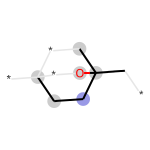

In [274]:
Draw.DrawMorganBit(mol, 1608, bi)

In [275]:
# from http://rdkit.blogspot.com/2018/10/using-new-fingerprint-bit-rendering-code.html
from ipywidgets import interact, fixed, IntSlider
def renderFpBit(mol, bitIdx, bitInfo, fn):
    bid = bitIdx
    
    return(display(fn(mol,bid,bitInfo)))

In [276]:
mol = Chem.MolFromSmiles(bit_1608s.canonical_smiles[4422])

In [277]:
bi = {}
vect = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
# show 10 of the set bits:
list(vect.GetOnBits())[:10]

[59, 70, 80, 116, 168, 226, 251, 255, 290, 314]

In [278]:
interact(renderFpBit, bitIdx=list(bi.keys()),mol=fixed(mol),
         bitInfo=fixed(bi),fn=fixed(Draw.DrawMorganBit));
#interactive widget may not push to GitHub

interactive(children=(Dropdown(description='bitIdx', options=(59, 70, 80, 116, 168, 226, 251, 255, 290, 314, 3…

### Drug Discovery Antibiotic Molecule Generator

In [ ]:
!pip install --user tensorflow-gpu

In [281]:
!sudo rm /root/.local/lib/python3.7/site-packages/tensorflow/core/kernels/libtfkernel_sobol_op.so

In [282]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding

from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
import keras
import random
import sys

In [283]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import Sequence

In [284]:
df = pd.read_csv('acinetobacter_baumannii_MIC_addFeats_addBits.csv').drop(columns = 
                        'Unnamed: 0').drop_duplicates(subset = ['canonical_smiles'])

Creating a scaled target

In [285]:
df['pMIC'] = df['standard_value'].map(lambda x: -np.log10(x * (10**-9)))

In [286]:
df_active = df[df.bioactivity_binary == 'active'].sort_values(by = ['pMIC']).tail(200)

#### Molecule Generator

In [287]:
X = df_active.canonical_smiles

In [288]:
maxlen = 60 # can adjust
step = 3

In [289]:
smiles = [i for i in X]

In [290]:
smiles[0]

'CC(C)(O/N=C(\\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N+]3(CCNC(=O)c4ccc(O)c(O)c4Cl)CCCC3)CS[C@H]12)c1csc(N)n1)C(=O)O'

In [291]:
text = [''.join(i) for i in smiles] #making a big jumbles
                                    #instead of working with list of strings

In [292]:
text = ''.join(text)

In [293]:
print(f'Number of SMILES: {len(text)}')

Number of SMILES: 19570


In [294]:
# chars = [sorted(list(set(i))) for i in smiles]
# chars[0]

In [295]:
from itertools import chain

chars = set(chain.from_iterable(text))

In [296]:
chars_list = list(chars) #convert set to list

In [297]:
print(f'Number of unique characters: {len(chars)}')

Number of unique characters: 33


In [298]:
char_indices = dict((char, chars_list.index(char)) for char in chars_list)

In [299]:
len(char_indices)

33

In [300]:
#again -> delete
next_chars = []
sentences = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])

In [301]:
chars = sorted(list(text))

In [302]:
char_indices = dict((char, chars.index(char)) for char in chars)

In [303]:
#again -> delete
x = np.zeros((len(sentences), maxlen, len(chars)), dtype = np.bool)
y = np.zeros((len(sentences), len(chars)), dtype = np.bool)

In [304]:
# one-hot encoding
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [305]:
model = Sequential() 
#model.add(Embedding(input_dim = X_fgr.shape[1], output_dim = 128))
model.add(LSTM(128, input_shape = (maxlen, len(chars))))
# model.add(Dropout(0.2))
# model.add(LSTM(256, return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(512, return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(256, return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(128))
# model.add(Dropout(0.2))
# model.add(Dense(y.shape[0], activation='softmax'))

model.add(Dense(len(chars), activation = 'softmax'))

In [306]:
optimizer = keras.optimizers.RMSprop(lr = 0.01)

In [307]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer)

In [308]:
def reweight_distribution(original_distribution, temperature=0.5): 
    distribution = np.log(original_distribution) / temperature 
    distribution = np.exp(distribution)
    
    return distribution / np.sum(distribution)

In [309]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64') 
    preds = np.log(preds) / temperature 
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds) 
    probas = np.random.multinomial(1, preds, 1) 

    return np.argmax(probas)

In [310]:
checkpoint_list = []
generated_list = []

for epoch in range(1, 25): # less epochs - trained many times while
    print('epoch', epoch)  # troubleshooting
    model.fit(x, y, batch_size = 128, epochs = 1)
    start_index = random.randint(0, len(text) - maxlen -1)
    generated_text = text[start_index: start_index + maxlen]
    print(f'Generating with seed: {generated_text}')

    for temperature in [0.9]: #only one due to time
        print(f'temperature: {temperature}')
        sys.stdout.write(generated_text)

        for i in range(200):
            sampled = np.zeros((1, maxlen, len(chars)))

            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1

            preds = model.predict(sampled, verbose=1)[0] 
            next_index = sample(preds, temperature) 
            next_char = chars[next_index]
            
            generated_text += next_char
            checkpoint_list.append(generated_text)
            generated_text = generated_text[1:]
            generated_list.append(generated_text)
            
            sys.stdout.write(next_char)

epoch 1
51/51 [==============================] - 18s 311ms/step - loss: 4.0877
Generating with seed: OC4)nc2N1Cn1c(CNC2(C)CCC2)cc2cc3c(cc21)CCCc1c-3[nH]c(=O)c(C(
temperature: 0.9
1/1 [==============================] - 0s 22ms/step
4epoch 2
51/51 [==============================] - 16s 313ms/step - loss: 2.2618
Generating with seed: CCCCCc1ccc(-c2cn(CC)c(N)n2)cc1CN1CCCC1c1cc(O)c2c(c1Cl)C[C@H]
temperature: 0.9
1/1 [==============================] - 0s 23ms/step
2epoch 3
51/51 [==============================] - 16s 311ms/step - loss: 1.5545
Generating with seed: [C@H](O)C(=O)N[C@@H]1C[C@H](N)[C@@H](O[C@H]2OC(CN)=CC[C@H]2N
temperature: 0.9
1/1 [==============================] - 0s 22ms/step
2epoch 4
51/51 [==============================] - 16s 310ms/step - loss: 1.2935
Generating with seed: CN)NC1=O)[C@@H](C)OCN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C
temperature: 0.9
1/1 [==============================] - 0s 22ms/step
(epoch 5
51/51 [==============================] - 16s 312ms/step - loss: 

In [311]:
generated_text

'1)NCC(C)(O/N=C(\\C(=O)N[C@H]1CCNC(=O)[C@H](CC(C)C)NC(=O)[C@H]'

In [312]:
preds

array([9.9019548e-10, 4.6128471e-13, 4.6933063e-13, ..., 4.5945653e-13,
       4.3672059e-13, 4.4106689e-13], dtype=float32)

In [313]:
generated_list[0]

'C4)nc2N1Cn1c(CNC2(C)CCC2)cc2cc3c(cc21)CCCc1c-3[nH]c(=O)c(C(C'

In [314]:
checkpoint_list[1000]

'@@]2(O)C(O)=C3C(=O)c4c(O)c(NC(=O)CNC(C)(C)C)cc(F)c4C[C@H]3C[N'

In [315]:
pd.Series(generated_list).to_csv('generated_list_1')

4801 unique strings were generated, but due to the small training size, there isn't a lot of variation.

In [316]:
%%writefile drug_discovery_pipe_app_v1-accuracy.py

#import libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client
import numpy as np

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

import warnings
warnings.filterwarnings("ignore")

from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem.Fingerprints import FingerprintMols

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import streamlit as st
import pickle
import time

from PIL import Image
from io import BytesIO

# intro & formatting

st.markdown(
    """
<style>
.reportview-container .markdown-text-container {
    
    font-family: IBM Plex Sans;
}
.sidebar .sidebar-content {
    background-image: url("https://i.pinimg.com/originals/53/3e/f4/533ef47e9ffb0f69f644e307696931b5.jpg");
    color: white;
}
.Widget>label {
    color: white;
    font-family: monospace;
}
[class^="st-b"]  {
    color: white;
    font-family: monospace;
}
.st-bb {
    background-color: #d19da6;
}
.st-at {
    background-color: #3d393a;
}
footer {
    font-family: monospace;

}
.reportview-container .main footer, .reportview-container .main footer a {
    color: #013d29;
}
header .decoration {
    background-image: url("https://img2.mahoneswallpapershop.com/prodimage/ProductImage/560/aecd25f8-4822-42ca-85f7-62d63cd41fc3.jpg");
}

</style>
""",
    unsafe_allow_html=True,
)

st.title('💊 Drug Discovery Pipeline')
st.text('by Corey J Sinnott')
st.subheader('This app creates a model from every available drug in the \
              ChEMBL database, and will return a Minimum Inhibitory \
              Concentration (**MIC**) prediction for your compound\
              in **nM**.')

# ------------ dataframe creation ------------ #

def target_search(user_enter_organism):
    """
    Searches the ChEMBL database for a target organism; 
    filters for available relevant data.

    Args: User input of a bacteria name.

    Returns: cleaned dataframe of necessary information.
    """
    #user_enter_organism = st.text_input('organism name') #outside of function? input as entry?
    st.spinner()
    with st.spinner(text='Target Search In-Progress'):
        
        target = new_client.target
        time.sleep(3)
        target_search = target.search(user_enter_organism)
        st.write('- organism obtained ✔️')
        time.sleep(3)
        target_df = pd.DataFrame.from_dict(target_search)
        st.write('- drugs obtained ✔️')
        time.sleep(3)
        select_target = target_df.target_chembl_id[0]
        time.sleep(3)
        activity = new_client.activity
        time.sleep(3)
        res = activity.filter(target_chembl_id = select_target).filter(standard_type=['MIC'])
        time.sleep(1)
        df_test = pd.DataFrame.from_dict(res)
        time.sleep(1)
        df_test['standard_value'] = df_test['standard_value'].astype(float)
        time.sleep(1)
        df_trim = df_test.dropna(subset = ['standard_value', 'canonical_smiles'])
        df = df_trim[['canonical_smiles', 'standard_value']].drop_duplicates(subset = ['canonical_smiles'])
        st.success('Target search complete')
    return df


# ------------ feature engineering ------------ #

def bioactivity_rater(df):
    #paste in rater if needed
    #will require a percentile calc
    pass

def add_mol_feats_v2(df, df_col):
    """
    Creates a new dataframe with four new molecular descriptors: molecular
    weight, log P, proton donors, and proton acceptors.
    
    Args: dataframe column containing SMILES
    
    Returns: new dataframe of molecular features
    """

    st.spinner()
    with st.spinner(text='Featurization In-Progress'):

        mol_wt   = [round(Descriptors.MolWt(Chem.MolFromSmiles(i)), 3) for i in df_col]
        st.write('- molecular weight added ✔️')
        log_p    = [Descriptors.MolLogP(Chem.MolFromSmiles(i)) for i in df_col]
        st.write('- log-p added ✔️')
        H_donors = [Lipinski.NumHDonors(Chem.MolFromSmiles(i)) for i in df_col]
        st.write('- proton donors added ✔️')
        H_accept = [Lipinski.NumHAcceptors(Chem.MolFromSmiles(i)) for i in df_col]
        st.write('- proton acceptors added ✔️')
        # can add more features as needed
        
        mol_array = np.array([mol_wt,
                            log_p,
                            H_donors,
                            H_accept])
        
        mol_array_trans = np.transpose(mol_array)
        
        mol_df = pd.DataFrame(data = mol_array_trans, 
                            columns = [
                                'mol_wt',
                                'log_p',
                                'proton_donors',
                                'proton_acceptors'
                                            ])
        
        df_2 = pd.concat([df.reset_index(), mol_df], axis = 1)
        st.success('Featurization complete')

    return df_2 #O(n^4)

def finger_printer(df):
    """
    Creates a vectorized representation of SMILES using Morgan's Fingerprint Algorithm
    
    Args: Dataframe

    Returns: Dataframe with fingerprints
    """
    col = df['canonical_smiles']

    ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(i), 3) for i in col] 
    ECFP6_list = [list(i) for i in ECFP6]
    ECFP6_names = [f'Bit_{i}' for i in range(2048)]
    ECFP6_df = pd.DataFrame(ECFP6_list, index = df.index, columns = ECFP6_names)
    
    st.write('- Morgan fingerprinting complete ✔️')

    df_3 = pd.concat([df.reset_index(drop = True), ECFP6_df], axis = 1)
    
    return df_3 #O(n^3)

def pMIC(df):
    """
    Converts standard value (MIC) to a -log10 standardized value for 
    better distribution.

    Args: df

    Returns: df with new columns
    """
    st.write('standardizing target values with -log10')

    df['pMIC'] = df['standard_value'].map(lambda x: -np.log10(x * (10**-9)))

    st.write('- target values standardized')

    return df_4

# ------------ modeling ------------ #    

def regression_and_eval(df):
    """
    Takes in x and y variables, and fits a regression model.

    Args: X, y, model

    Returns: trained model, X_train, X_test, y_train, y_test, y_pred
    """
    df['pMIC'] = df['standard_value'].map(lambda x: -np.log10(x * (10**-9)))

    st.subheader('Analyzing')
    
    X = df.drop(columns = ['canonical_smiles',
                           'standard_value',
                           'pMIC', 'index'])
    #y = df['pMIC']
    y = df['standard_value']

    ss = StandardScaler()
    num_cols = ['mol_wt', 'log_p', 'proton_donors', 'proton_acceptors']
    X[num_cols] = ss.fit_transform(X[num_cols])

    model = RandomForestRegressor()

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2219)
    null_y = np.full_like(y_train, y.mean())

    st.spinner()
    with st.spinner(text='Random Forest regression in-progress ...'):

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        st.success('Modeling complete')

    null_MSE = mean_squared_error(y_train, null_y)
    MSE = mean_squared_error(y_test, y_pred)

    f'Null MSE = {np.round(mean_squared_error(y_train, null_y), 3)}'
    f'MSE   = {np.round(mean_squared_error(y_test, y_pred), 3)}'
    f'RMSE  = {np.round(mean_squared_error(y_test, y_pred, squared = False), 3)}'
    f'MAE   = {np.round(mean_absolute_error(y_test, y_pred), 3)}'
    f'r^2   = {np.round(r2_score(y_test, y_pred), 3)}'
    #f'MSE% greater than null = {(np.abs(np.round(((null_MSE - MSE) / null_MSE), 3)))*100}%'

    return model

# ------------------ input processing ------------------------ #

def prediction_prep(smile):
    """
    Prepares the SMILE inputted by the user for analysis.
    
    Args: SMILE.
    
    Returns: SMILE with appropriate features and vectorization.
    """
    st.spinner()
    with st.spinner(text='Featurizing your molecule and making prediction ...'):
        ss = StandardScaler()

        #adding Lipinkis
        mol_wt   = round(Descriptors.MolWt(Chem.MolFromSmiles(smile)), 3)
        st.write(f'- molecular weight added [{mol_wt}]')
        log_p    = round(Descriptors.MolLogP(Chem.MolFromSmiles(smile)), 3)
        st.write(f'- log-p added [{log_p}] ✔️')
        H_donors = Lipinski.NumHDonors(Chem.MolFromSmiles(smile))
        st.write(f'- proton donors added [{H_donors}]')
        H_accept = Lipinski.NumHAcceptors(Chem.MolFromSmiles(smile))
        st.write(f'- proton acceptors added [{H_accept}]')
        
        feats_df = pd.DataFrame([mol_wt, log_p, H_donors, H_accept])
        feats_df = pd.DataFrame(ss.fit_transform(feats_df))
        feats_df = feats_df.T
        feats_df = feats_df.rename(columns = {0 : 'Mol Wt.', 
                                              1 : 'log P',
                                              2 : 'Proton Donors',
                                              3 : 'Proton Acceptors' 
                                                    })
        #vectorizing
        prints = list(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), 3))
        prints_df = pd.DataFrame(prints).T

        X_user = pd.concat([feats_df, prints_df], axis = 1)

        st.write('- Morgan fingerprinting complete')
        st.success('Featurization complete')
    return X_user

# -------------------- interface --------------------------- #

with st.sidebar.header('Enter an organism 🦠 and a SMILE 🧪 to get started.'):
    user_enter_organism = st.sidebar.text_input('🦠 Organism:')
    user_smile = st.sidebar.text_input('🧪 SMILE:')
    button = st.button('Submit')

if button:
    df = target_search(user_enter_organism)
    df_2 = add_mol_feats_v2(df, df['canonical_smiles'])
    df_3 = finger_printer(df_2)
    #df_4 = pMIC(df_3)
    model = regression_and_eval(df_3)
    time.sleep(1)
    st.subheader('Making prediction')
    X_user = prediction_prep(user_smile)
    time.sleep(1)
    prediction = model.predict(X_user)
    # displays molecule image
    img = Draw.MolToImage(Chem.MolFromSmiles(user_smile))
    bio = BytesIO()
    img.save(bio, format='png')
    st.image(img)
    st.write(user_smile)
    st.subheader(f'Predicted MIC: {round((prediction[0]), 2)}nM') 

# re-running with trained model
    next_button = st.button('Make another prediction')
    while next_button:
        user_smile = st.text_input('Next SMILE')
        st.subheader('Making prediction')
        X_user = prediction_prep(user_smile)
        time.sleep(1)
        prediction = model.predict(X_user)
        # displays molecule image
        img = Draw.MolToImage(Chem.MolFromSmiles(user_smile))
        bio = BytesIO()
        img.save(bio, format='png')
        st.image(img)
        st.write(user_smile)
        st.subheader(f'Predicted MIC: {round((prediction[0]), 2)}nM') 

Writing drug_discovery_pipe_app_v1-accuracy.py


In [317]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2021-07-02 01:16:56--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.195.15.150, 52.55.225.227, 52.71.109.149, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.195.15.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  11.5MB/s    in 1.1s    

2021-07-02 01:16:57 (11.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]



In [318]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [375]:
get_ipython().system_raw('./ngrok http 8501 &')

In [376]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Execute the next cell and the go to the following URL: http://7ed1935894bd.ngrok.io


In [ ]:
!streamlit run drug_discovery_pipe_app_v1-accuracy.py

In [377]:
%%writefile drug_discovery_pipe_app_v2-speed.py

#import libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client
import numpy as np

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

import warnings
warnings.filterwarnings("ignore")

from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem.Fingerprints import FingerprintMols

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import streamlit as st
import pickle
import time

from PIL import Image
from io import BytesIO
from sklearn.neighbors import KNeighborsRegressor

#streamlit intro
#st.header('wow, nice header')
st.markdown(
    """
<style>
.reportview-container .markdown-text-container {
    
    font-family: IBM Plex Sans;
}
.sidebar .sidebar-content {
    background-image: url("https://i.pinimg.com/originals/53/3e/f4/533ef47e9ffb0f69f644e307696931b5.jpg");
    color: white;
}
.Widget>label {
    color: white;
    font-family: monospace;
}
[class^="st-b"]  {
    color: white;
    font-family: monospace;
}
.st-bb {
    background-color: #d19da6;
}
.st-at {
    background-color: #3d393a;
}
footer {
    font-family: monospace;

}
.reportview-container .main footer, .reportview-container .main footer a {
    color: #013d29;
}
header .decoration {
    background-image: url("https://img2.mahoneswallpapershop.com/prodimage/ProductImage/560/aecd25f8-4822-42ca-85f7-62d63cd41fc3.jpg");
}

</style>
""",
    unsafe_allow_html=True,
)

st.title('💊 Drug Discovery Pipeline')
st.text('by Corey J Sinnott')
st.subheader('This app creates a model from every available drug in the \
              ChEMBL database, and will return a Minimum Inhibitory \
              Concentration (**MIC**) prediction for your compound\
              in **nM**.')

# ------------ dataframe creation ------------ #

def target_search(user_enter_organism):
    """
    Searches the ChEMBL database for a target organism; 
    filters for available relevant data.

    Args: User input of a bacteria name.

    Returns: cleaned dataframe of necessary information.
    """
    #user_enter_organism = st.text_input('organism name') #outside of function? input as entry?
    st.spinner()
    with st.spinner(text='Target Search In-Progress'):
        
        target = new_client.target
        time.sleep(3)
        target_search = target.search(user_enter_organism)
        st.write('- organism obtained ✔️')
        time.sleep(3)
        target_df = pd.DataFrame.from_dict(target_search)
        st.write('- drugs obtained ✔️')
        time.sleep(3)
        select_target = target_df.target_chembl_id[0]
        time.sleep(3)
        activity = new_client.activity
        time.sleep(3)
        res = activity.filter(target_chembl_id = select_target).filter(standard_type=['MIC'])
        time.sleep(1)
        df_test = pd.DataFrame.from_dict(res)
        time.sleep(1)
        df_test['standard_value'] = df_test['standard_value'].astype(float)
        time.sleep(1)
        df_trim = df_test.dropna(subset = ['standard_value', 'canonical_smiles'])
        df = df_trim[['canonical_smiles', 'standard_value']].drop_duplicates(subset = ['canonical_smiles'])
        st.success('Target search complete')
    return df


# ------------ feature engineering ------------ #

def bioactivity_rater(df):
    #paste in rater if needed
    #will require a percentile calc
    pass

def add_mol_feats_v2(df, df_col):
    """
    Creates a new dataframe with four new molecular descriptors: molecular
    weight, log P, proton donors, and proton acceptors.
    
    Args: dataframe column containing SMILES
    
    Returns: new dataframe of molecular features
    """

    st.spinner()
    with st.spinner(text='Featurization In-Progress'):

        mol_wt   = [round(Descriptors.MolWt(Chem.MolFromSmiles(i)), 3) for i in df_col]
        st.write('- molecular weight added ✔️')
        log_p    = [Descriptors.MolLogP(Chem.MolFromSmiles(i)) for i in df_col]
        st.write('- log-p added ✔️')
        H_donors = [Lipinski.NumHDonors(Chem.MolFromSmiles(i)) for i in df_col]
        st.write('- proton donors added ✔️')
        H_accept = [Lipinski.NumHAcceptors(Chem.MolFromSmiles(i)) for i in df_col]
        st.write('- proton acceptors added ✔️')
        # can add more features as needed
        
        mol_array = np.array([mol_wt,
                            log_p,
                            H_donors,
                            H_accept])
        
        mol_array_trans = np.transpose(mol_array)
        
        mol_df = pd.DataFrame(data = mol_array_trans, 
                            columns = [
                                'mol_wt',
                                'log_p',
                                'proton_donors',
                                'proton_acceptors'
                                            ])
        
        df_2 = pd.concat([df.reset_index(), mol_df], axis = 1)
        st.success('Featurization complete')

    return df_2 #O(n^4)

def finger_printer(df):
    """
    Creates a vectorized representation of SMILES using Morgan's Fingerprint Algorithm
    
    Args: Dataframe

    Returns: Dataframe with fingerprints
    """
    col = df['canonical_smiles']

    ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(i), 3) for i in col] 
    ECFP6_list = [list(i) for i in ECFP6]
    ECFP6_names = [f'Bit_{i}' for i in range(2048)]
    ECFP6_df = pd.DataFrame(ECFP6_list, index = df.index, columns = ECFP6_names)
    
    st.write('- Morgan fingerprinting complete ✔️')

    df_3 = pd.concat([df.reset_index(drop = True), ECFP6_df], axis = 1)
    
    return df_3 #O(n^3)

def pMIC(df):
    """
    Converts standard value (MIC) to a -log10 standardized value for 
    better distribution.

    Args: df

    Returns: df with new columns
    """
    st.write('standardizing target values with -log10')

    df['pMIC'] = df['standard_value'].map(lambda x: -np.log10(x * (10**-9)))

    st.write('- target values standardized')

    return df_4

# ------------ modeling ------------ #    

def regression_and_eval(df):
    """
    Takes in x and y variables, and fits a regression model.

    Args: X, y, model

    Returns: trained model, X_train, X_test, y_train, y_test, y_pred
    """
    df['pMIC'] = df['standard_value'].map(lambda x: -np.log10(x * (10**-9)))

    st.subheader('Analyzing')
    
    X = df.drop(columns = ['canonical_smiles',
                           'standard_value',
                           'pMIC', 'index'])
    #y = df['pMIC']
    y = df['standard_value']

    ss = StandardScaler()
    num_cols = ['mol_wt', 'log_p', 'proton_donors', 'proton_acceptors']
    X[num_cols] = ss.fit_transform(X[num_cols])

    # model = RandomForestRegressor()
    model = KNeighborsRegressor()

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2219)
    null_y = np.full_like(y_train, y.mean())

    st.spinner()
    with st.spinner(text='KNeighbors regression in-progress ...'):

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        st.success('Modeling complete')

    null_MSE = mean_squared_error(y_train, null_y)
    MSE = mean_squared_error(y_test, y_pred)

    f'Null MSE = {np.round(mean_squared_error(y_train, null_y), 3)}'
    f'MSE   = {np.round(mean_squared_error(y_test, y_pred), 3)}'
    f'RMSE  = {np.round(mean_squared_error(y_test, y_pred, squared = False), 3)}'
    f'MAE   = {np.round(mean_absolute_error(y_test, y_pred), 3)}'
    f'r^2   = {np.round(r2_score(y_test, y_pred), 3)}'
    #f'MSE% greater than null = {(np.abs(np.round(((null_MSE - MSE) / null_MSE), 3)))*100}%'

    return model

# ------------------ input processing ------------------------ #

def prediction_prep(smile):
    """
    Prepares the SMILE inputted by the user for analysis.
    
    Args: SMILE.
    
    Returns: SMILE with appropriate features and vectorization.
    """
    st.spinner()
    with st.spinner(text='Featurizing your molecule and making prediction ...'):
        ss = StandardScaler()

        #adding Lipinkis
        mol_wt   = round(Descriptors.MolWt(Chem.MolFromSmiles(smile)), 3)
        st.write(f'- molecular weight added [{mol_wt}]')
        log_p    = round(Descriptors.MolLogP(Chem.MolFromSmiles(smile)), 3)
        st.write(f'- log-p added [{log_p}] ✔️')
        H_donors = Lipinski.NumHDonors(Chem.MolFromSmiles(smile))
        st.write(f'- proton donors added [{H_donors}]')
        H_accept = Lipinski.NumHAcceptors(Chem.MolFromSmiles(smile))
        st.write(f'- proton acceptors added [{H_accept}]')
        
        feats_df = pd.DataFrame([mol_wt, log_p, H_donors, H_accept])
        feats_df = pd.DataFrame(ss.fit_transform(feats_df))
        feats_df = feats_df.T
        feats_df = feats_df.rename(columns = {0 : 'Mol Wt.', 
                                              1 : 'log P',
                                              2 : 'Proton Donors',
                                              3 : 'Proton Acceptors' 
                                                    })
        #vectorizing
        prints = list(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), 3))
        prints_df = pd.DataFrame(prints).T

        X_user = pd.concat([feats_df, prints_df], axis = 1)

        st.write('- Morgan fingerprinting complete')
        st.success('Featurization complete')
    return X_user

# -------------------- interface --------------------------- #

with st.sidebar.header('Enter an organism 🦠 and a SMILE 🧪 to get started.'):
    user_enter_organism = st.sidebar.text_input('🦠 Organism:')
    user_smile = st.sidebar.text_input('🧪 SMILE:')
    button = st.button('Submit')

if button:
    df = target_search(user_enter_organism)
    df_2 = add_mol_feats_v2(df, df['canonical_smiles'])
    df_3 = finger_printer(df_2)
    #df_4 = pMIC(df_3)
    model = regression_and_eval(df_3)
    time.sleep(1)
    st.subheader('Making prediction')
    X_user = prediction_prep(user_smile)
    time.sleep(1)
    prediction = model.predict(X_user)
    # displays molecule image
    img = Draw.MolToImage(Chem.MolFromSmiles(user_smile))
    bio = BytesIO()
    img.save(bio, format='png')
    st.image(img)
    st.write(user_smile)
    st.subheader(f'Predicted MIC: {round((prediction[0]), 2)}nM') 

# re-running with trained model
    next_button = st.button('Make another prediction')
    while next_button:
        user_smile = st.text_input('Next SMILE')
        st.subheader('Making prediction')
        X_user = prediction_prep(user_smile)
        time.sleep(1)
        prediction = model.predict(X_user)
        # displays molecule image
        img = Draw.MolToImage(Chem.MolFromSmiles(user_smile))
        bio = BytesIO()
        img.save(bio, format='png')
        st.image(img)
        st.write(user_smile)
        st.subheader(f'Predicted MIC: {round((prediction[0]), 2)}nM') 

Writing drug_discovery_pipe_app_v2-speed.py


In [ ]:
get_ipython().system_raw('./ngrok http 8501 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

In [ ]:
!streamlit run drug_discovery_pipe_app_v2-speed.py